# SETTING UP NOTEBOOK

In [1]:
'''IMPORTING DIFFERENT NECESSARY LIBRARIES'''

import matplotlib, logging, os, anndata, scanorama, csv, gzip, math

import scanpy as sc
import numpy as np
import scipy as sp
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler
import scrublet as scr
import matplotlib.patches as mpatches

In [2]:
'''PROVIDING THE PROGRAM A DIRECT PATH TO REACH R'''

os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.2"

In [3]:
import rpy2, anndata2ri
import rpy2.rinterface_lib.callbacks
import rpy2.robjects.numpy2ri
from rpy2.robjects import r, pandas2ri

In [4]:
'''SETTING UP NOTEBOOK FIGURE PARAMETERS'''

# Re-scaling Matplotlib Figures 
plt.rcParams['figure.figsize'] = (10,10)

# Re-scaling Scanpy Figures
sc.settings.set_figure_params(dpi = 80, facecolor = "white") 

In [5]:
'''SETTING UP R ENVIROMENT'''

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) #sets up communication between notebook and message logging

# Automatically convert rpy2 outputs to pandas dataframes
rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()
anndata2ri.activate()

# loads R into the notebook so you can use both R and Python in one notebook 
%load_ext rpy2.ipython 

# Setting the verbosity of the ouput in the terminal 
sc.settings.verbosity = 3
sc.set_figure_params(dpi = 200, dpi_save = 300)
sc.logging.print_versions()

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
anndata2ri                  1.1
annoy                       NA
asttokens                   NA
backcall                    0.2.0
cairocffi                   1.3.0
certifi                     2022.09.24
cffi                        1.15.1
charset_normalizer          2.1.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.3
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   1.1.1
fbpca                       NA
google                      NA
gprofiler                   NA
h5py                        3.7.0
idna                        3.4
igraph                      0.10.4
intervaltree                NA
ipykernel                   6.16.0
ipython_genutils            0.2.0
ipywidgets                  8.0.4
jedi              

In [ ]:
'''INSTALLING NECESSARY R PACKAGES IN THE CELL BELOW'''

In [6]:
%%R

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("scran")
BiocManager::install("slingshot")
BiocManager::install("monocle")
BiocManager::install("gam")
BiocManager::install("clusterExperiment")
BiocManager::install("MAST")

install.packages("locfit", dependencies = TRUE, repos = 'http://cran.rstudio.com/')
install.packages("irlba", dependencies = TRUE, repos = 'http://cran.rstudio.com/')
install.packages("igraph", dependencies = TRUE, repos = 'http://cran.rstudio.com/')
install.packages("ggplot2", dependencies = TRUE, repos = 'http://cran.rstudio.com/')
install.packages("plyr", dependencies = TRUE, repos = 'http://cran.rstudio.com/')

library(locfit)
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

Update all/some/none? [a/s/n]: n
Update all/some/none? [a/s/n]: n
Update all/some/none? [a/s/n]: n
Update all/some/none? [a/s/n]: n
Update all/some/none? [a/s/n]: n
Update all/some/none? [a/s/n]: n
package 'locfit' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Hlab\AppData\Local\Temp\RtmpoZe8xV\downloaded_packages
package 'irlba' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Hlab\AppData\Local\Temp\RtmpoZe8xV\downloaded_packages
package 'igraph' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Hlab\AppData\Local\Temp\RtmpoZe8xV\downloaded_packages
package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Hlab\AppData\Local\Temp\RtmpoZe8xV\downloaded_packages
package 'plyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Hlab\AppData\Local\Temp\RtmpoZe8xV\down

In [33]:
'''IMPORTING NECESSARY FUNCTIONS FROM PIPELINE FUNCTION FILE'''

%run Preprocessing_Pipeline_Functions.ipynb

In [8]:
'''READING ANNDATA FILES WITH RAW DATA'''

# Path with the location of the file 
directory = 'F:\Single_Cell_Seq_Python_Git\Mouse_Preprocessing_Pipeline\scanpy_mouse_RAW.h5ad'

# Holding AnnData file in 'adata' variable 
adata = sc.read_h5ad(directory)

In [9]:
'''CREATING A NEW ANNDATA OBJECT THAT ONLY CONTAINS THE DATA WE WANT TO ANALYZE'''

# Excluding the embryonic samples, batches 10 and 15
wantData = adata[adata.obs.batch.isin(["0","1","2","3","4","5","6","7","8","9","11","12","13","14","16","17"]),:]

In [10]:
'''SETTING DATA WE WANT TO USE TO THE "DATA" VARIABLE'''

# AnnData Object being used for filtering and processing from here on!! 
data = wantData 

# FILTERING

### Removing Mito, Ribo, and Hemo Genes

In [11]:
'''PREFIXES USED TO FILTER MT, RB AND HB GENES'''

riboPrefixes = ('Rps', 'Rpl', 'Mrp', 'Dap3')
mitoPrefixes = 'mt-'
hbPrefixes = 'Hbb'

In [12]:
'''RUN CELL TO VISUALIZE THE MT, RB, AND HB GENES FOUND IN THE DATA USING THE ABOVE PREFIXES'''

# Ribosomal Genes List
rbGenesFound, riboCount = findGenes(data, 'RIBOSOMAL', riboPrefixes)

# Mitochondrial Genes List
mtGenesFound, mitoCount = findGenes(data, 'MITOCHONDRIAL', mitoPrefixes)

# Hemoglobin Genes List
hbGenesFound, hemoCount = findGenes(data, 'HEMOGLOBIN', hbPrefixes)


RIBOSOMAL GENES PRESENT IN SAMPLE
Mrpl15
Rpl7
Mrpl30
Rpl31
Mrps9
Rpl37a
Mrpl44
Mrps14
Rps6kc1
Mrpl41
Rpl7a
Mrps2
Rpl12
Rpl35
Mrps5
Mrps26
Rps21
Mrps28
Rpl22l1
Mrpl47
Rps3a1
Mrpl24
Dap3
Rps27
Mrpl9
Mrps21
Rpl34
Rps20
Mrpl50
Rps6
Mrpl37
Rps8
Mrps15
Rps6ka1
Rpl11
Rpl22
Mrpl20
Mrpl33
Rpl9
Mrpl1
Mrps18c
Rpl5
Rplp0
Rpl6
Mrps17
Rpl21
Mrps33
Mrpl35
Mrpl19
Mrpl53
Mrps25
Rpl32
Mrpl51
Mrps35
Rps9
Rpl28
Rps5
Rps19
Rps16
Mrps12
Rps11
Rpl13a
Rpl18
Mrpl46
Mrps11
Rps17
Rps3
Mrpl48
Mrpl17
Rpl27a
Rps13
Rps15a
Rplp2
Mrpl23
Mrps31
Rpl18a
Mrpl34
Rpl13
Mrpl4
Rps25
Rpl10-ps3
Rplp1
Rpl4
Rps27l
Mrps22
Mrpl3
Rpl29
Rps27rt
Rpsa
Rpl14
Rps12
Rps15
Mrpl54
Mrpl42
Rpl41
Rps26
Mrps24
Rps27a
Mrpl22
Mrpl55
Rpl26
Rpl23a
Rpl9-ps1
Rps6kb1
Mrps23
Mrpl27
Mrpl10
Mrpl45
Rpl23
Rpl19
Rpl27
Rpl38
Mrpl58
Mrps7
Mrpl38
Mrpl12
Rps7
Rpl10l
Rps29
Rpl36al
Rps6kl1
Rps6ka5
Mrpl32
Mrpl36
Rps23
Mrps27
Mrps36
Mrps30
Rpl15
Mrps16
Rps24
Mrpl52
Mrpl57
Rpl36a-ps1
Rpl37
Rpl30
Mrpl13
Rpl8
Rpl3
Rps19bp1
Rpl39l
Mrpl40
Rpl35a
Rpl24
Mrpl39
Mrps6
Rps6

In [13]:
'''IDENTIFYING THE MT, RB, AND HB GENES IN DATA.VAR AND CALCULATING PERCENT OF MT, RB, AND HB GENES IN NUCLEI'''

# Identifying which genes are MT, RB, and HB
data.var['mt'] = data.var_names.str.startswith(mitoPrefixes) 
data.var['ribo'] = data.var_names.str.startswith(riboPrefixes)
data.var['hb'] = data.var_names.str.startswith(hbPrefixes) 
    
# Calculates Gene and Nuclei Counts Information
sc.pp.calculate_qc_metrics(data, qc_vars=['mt','ribo','hb'], percent_top = None, log1p = False, inplace = True)

print('Initial number of Nuclei: {:d}'.format(data.n_obs))
print('Initial number of Genes: {:d}'.format(data.n_vars))

C:\Users\Hlab\AppData\Local\Temp\ipykernel_17768\3620597394.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  data.var['mt'] = data.var_names.str.startswith(mitoPrefixes)


Initial number of Nuclei: 138562
Initial number of Genes: 32285


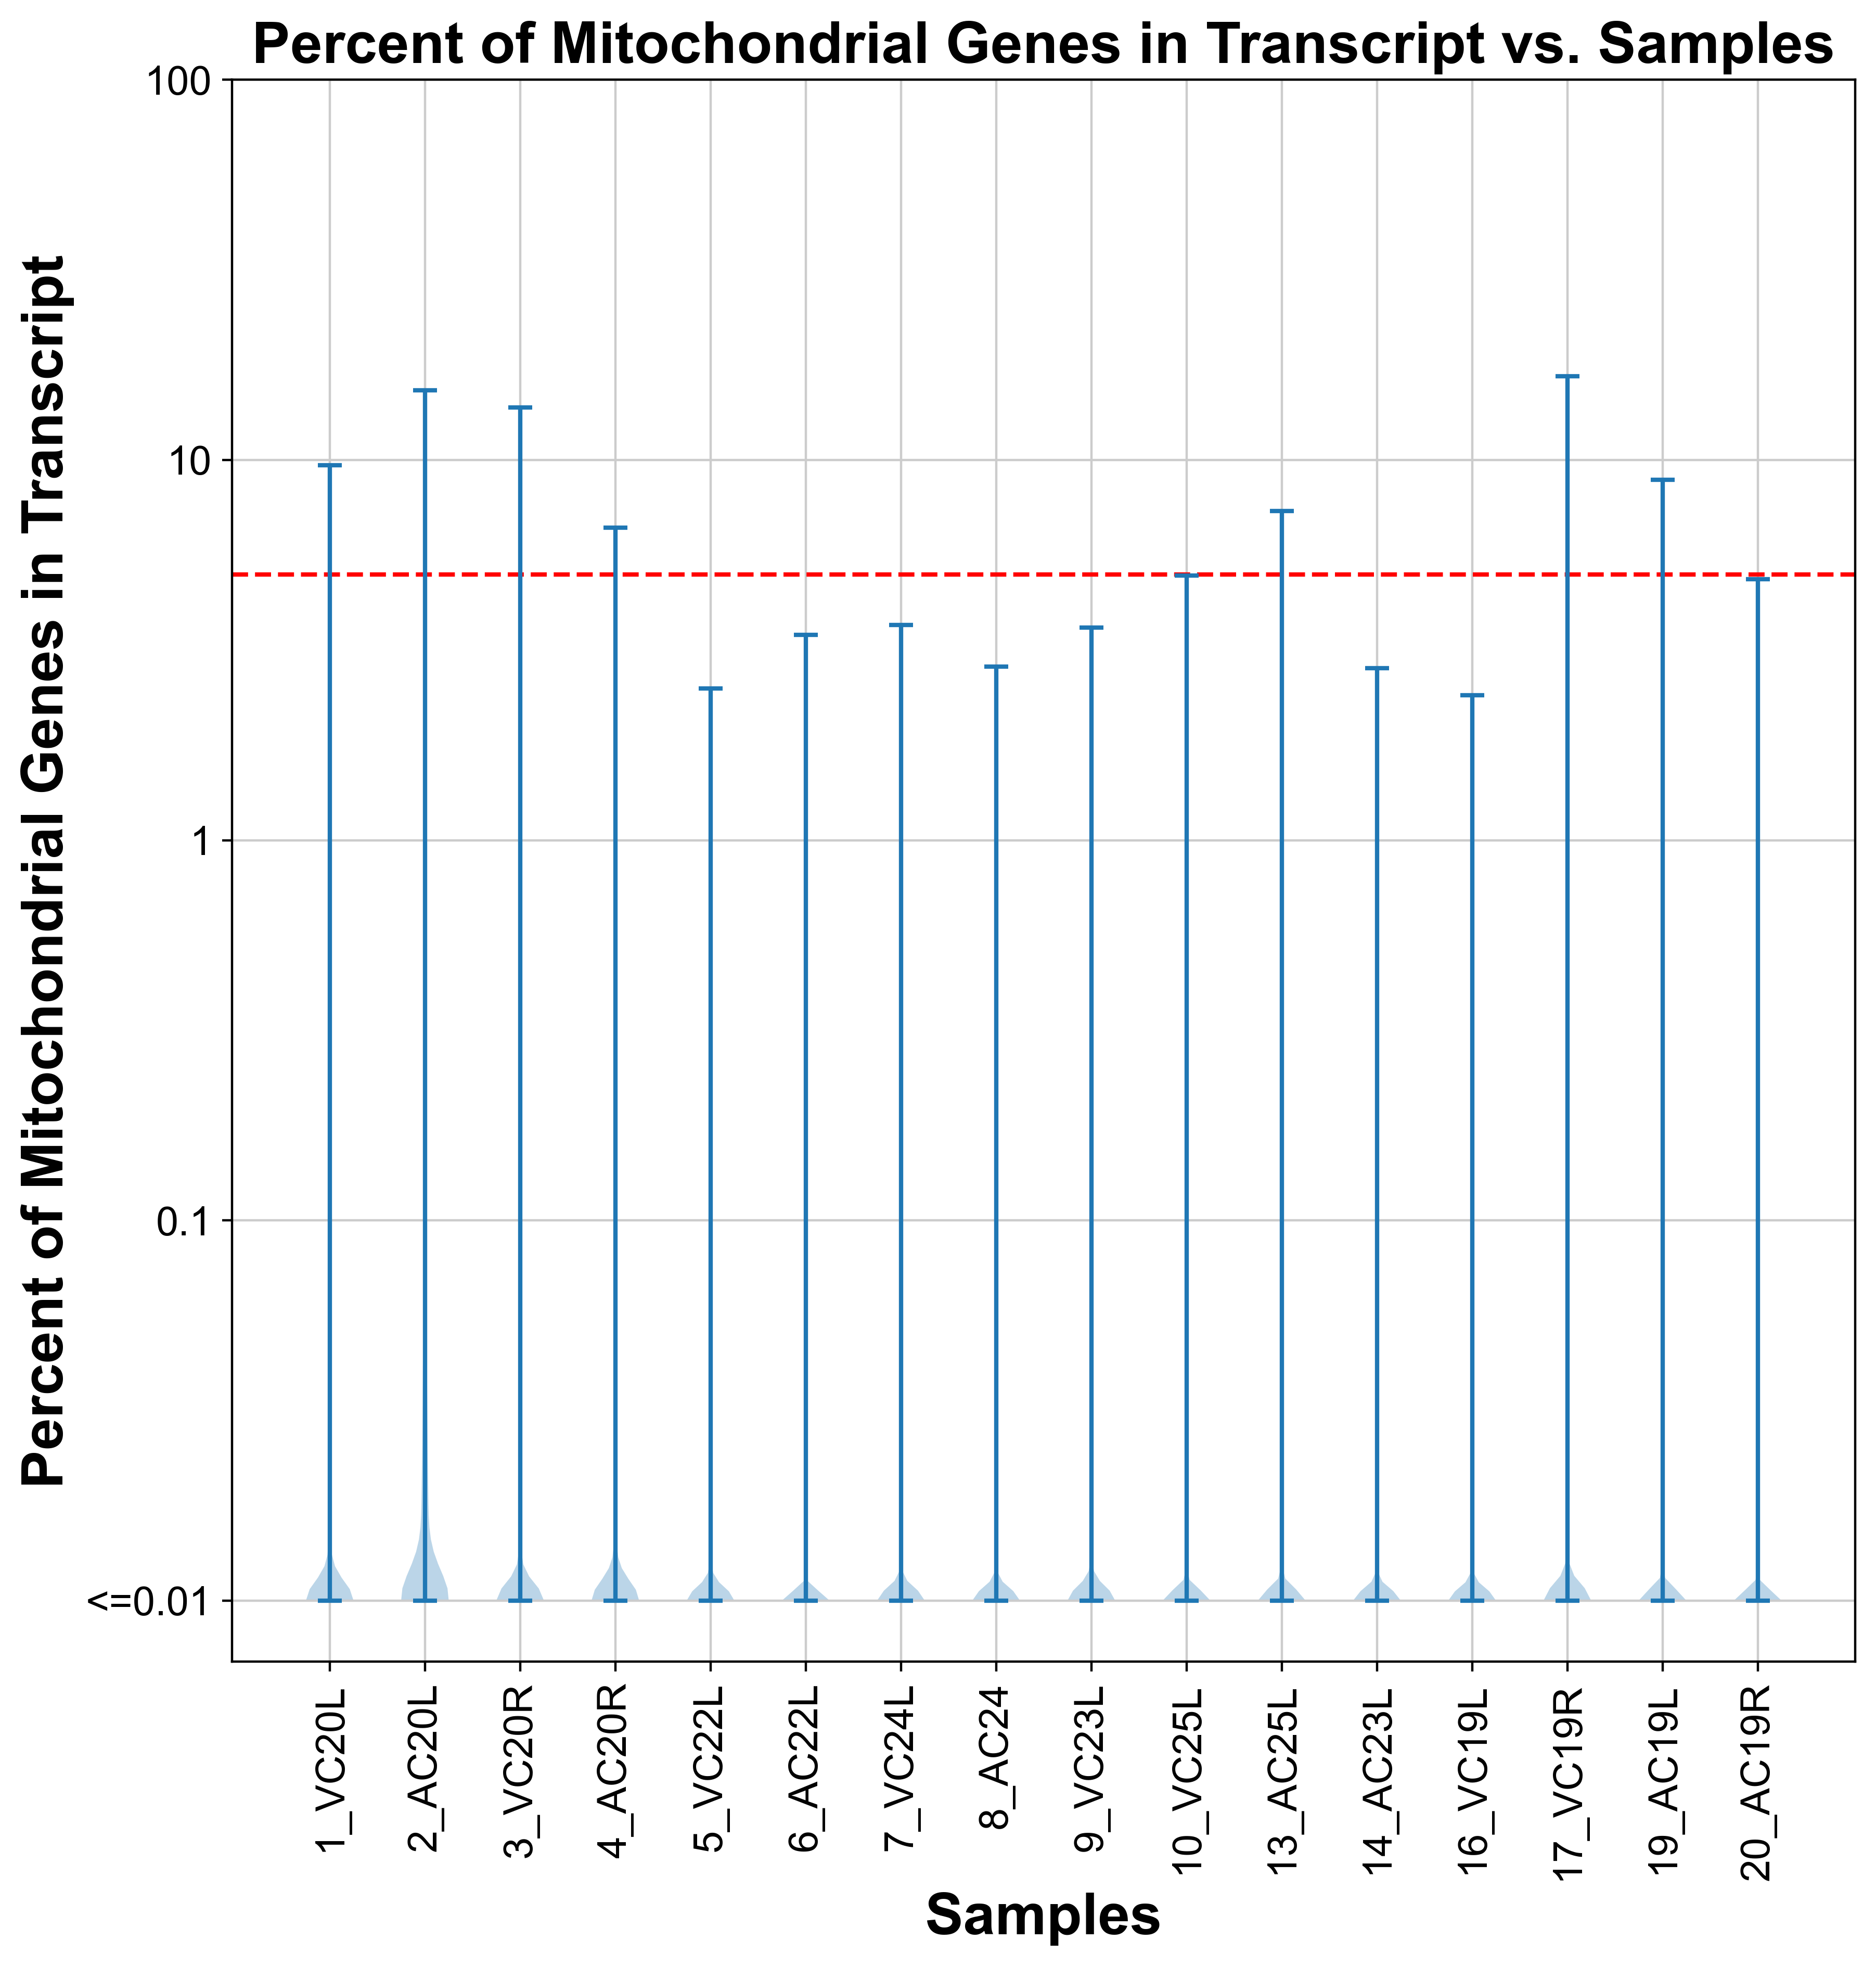

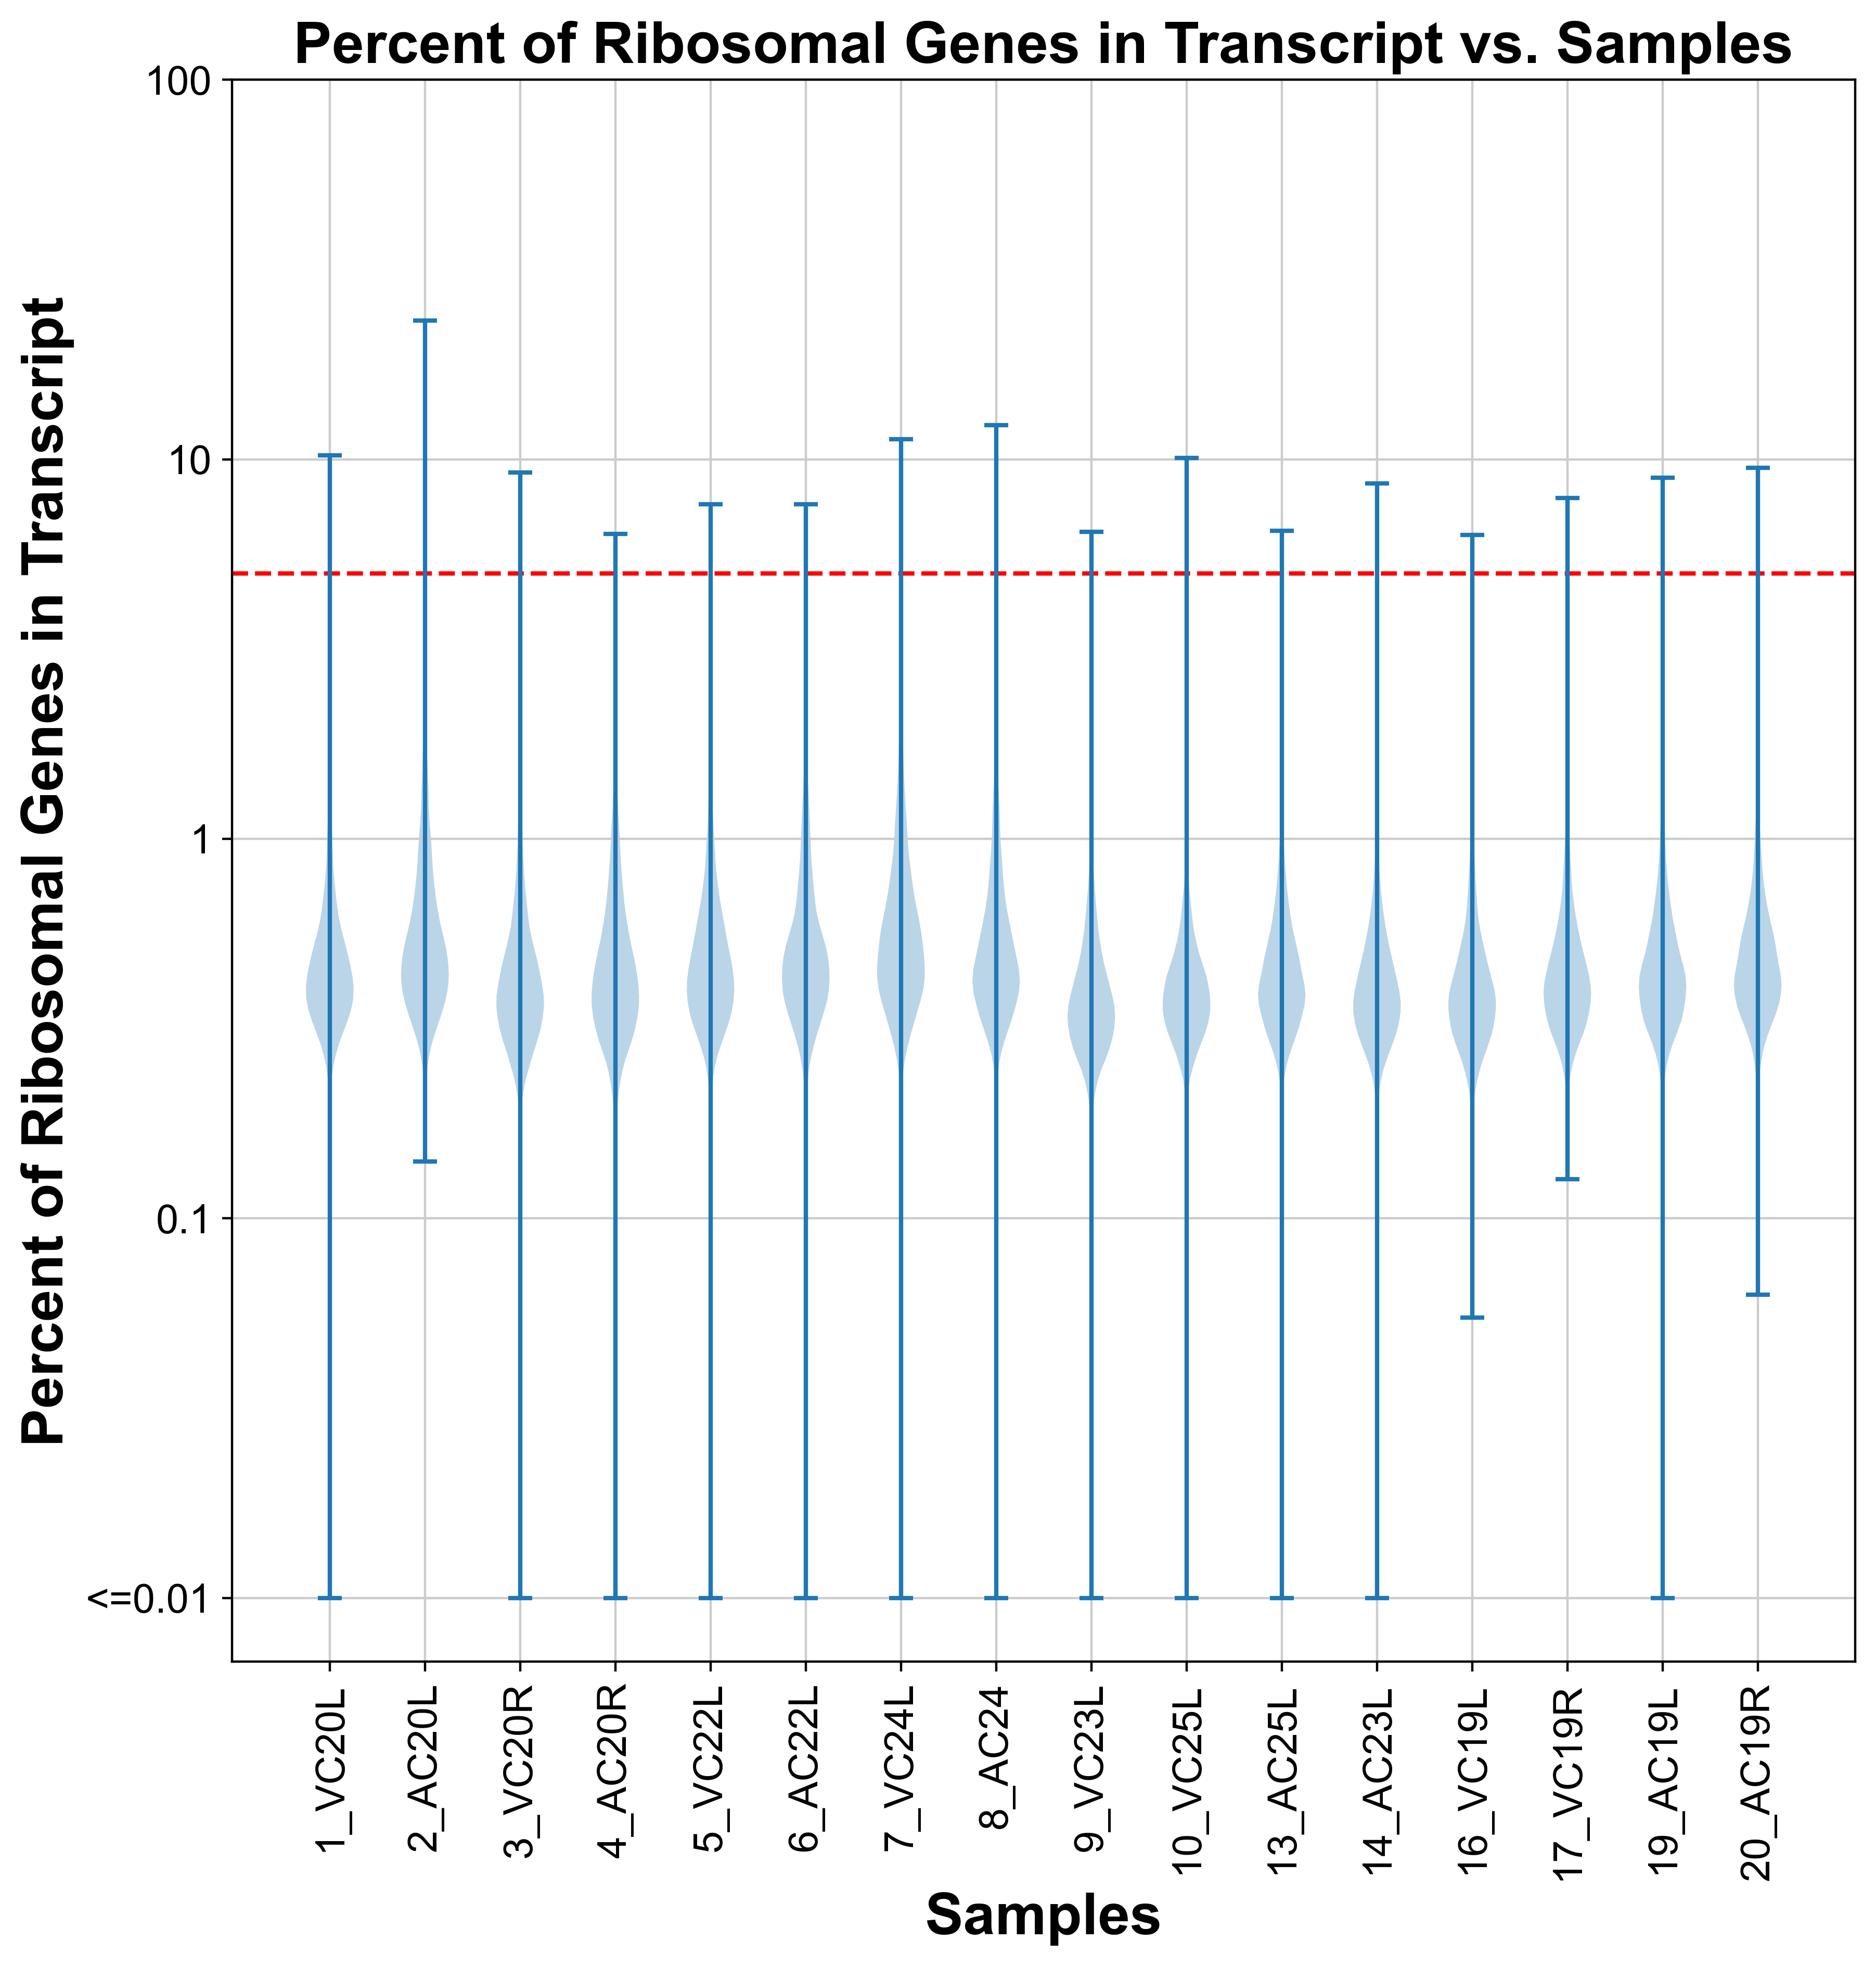

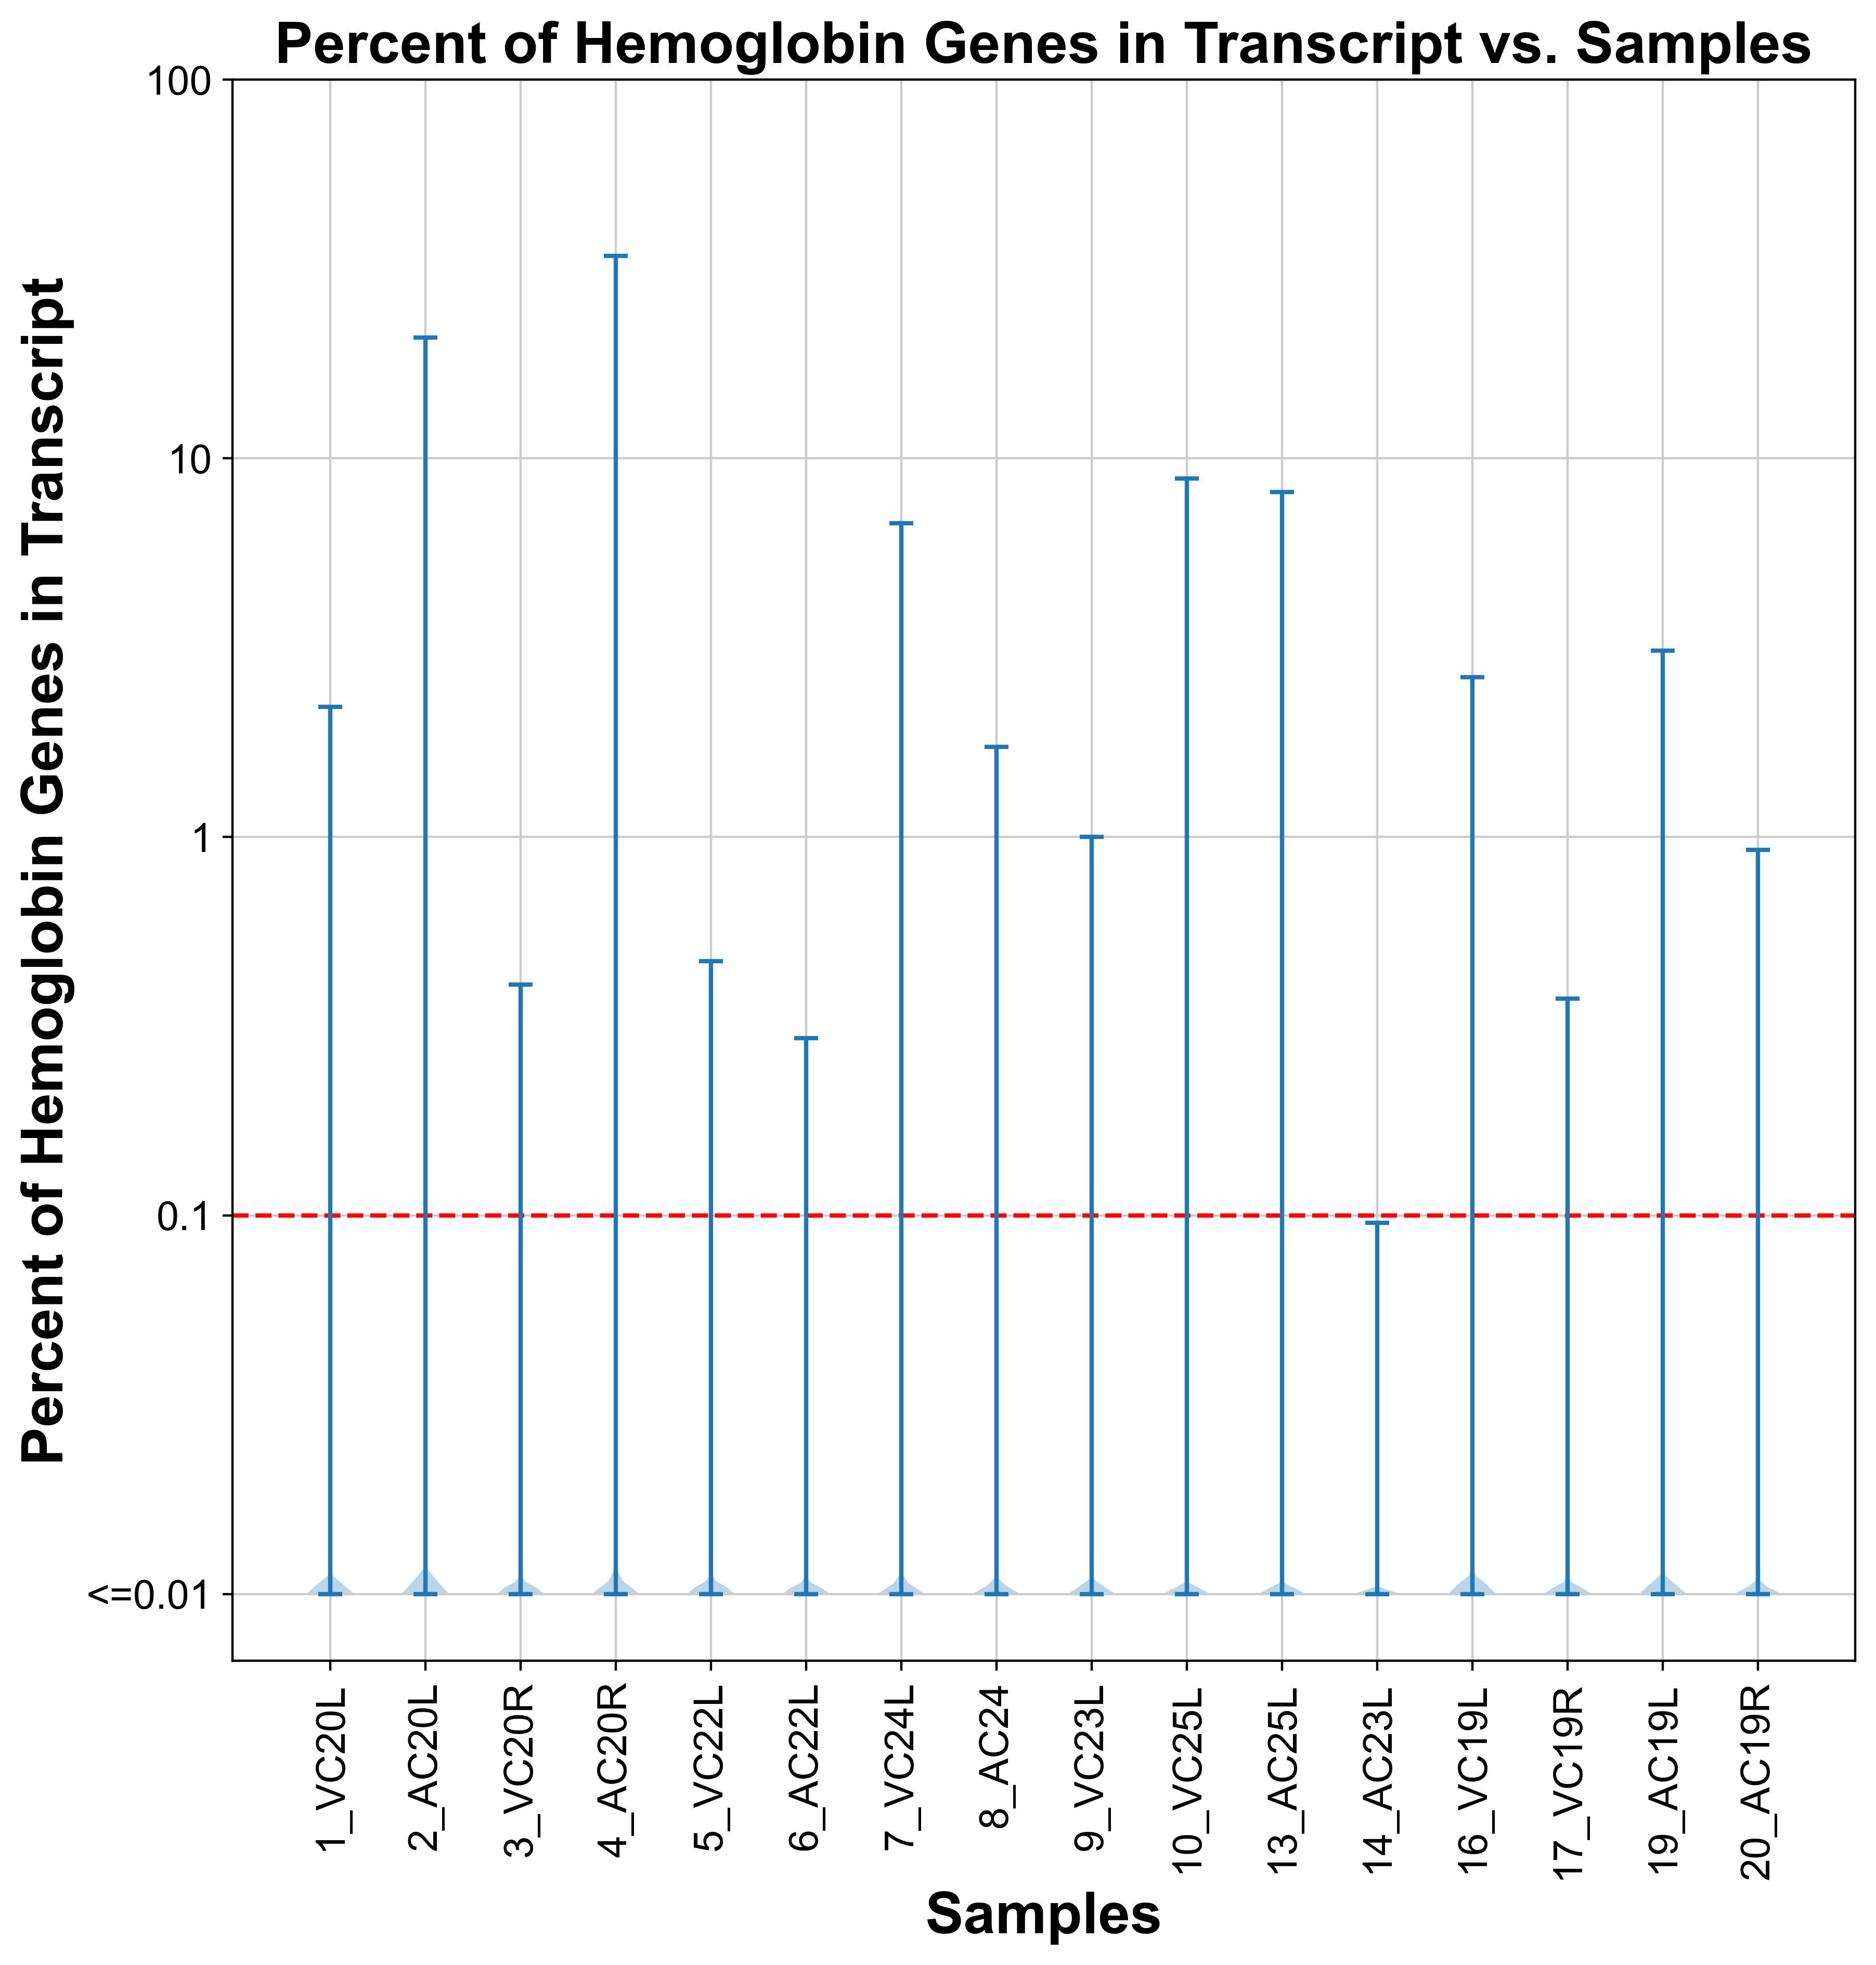

In [14]:
'''PRE-FILTER VIOLIN PLOTS OF PERCENT MT, RB, AND HB GENES PER SAMPLE'''

violinFilterPlot(data, 'pct_counts_mt', 0.69897000433, [2, 1, 0, -1, -2], [100, 10, 1, 0.1, '<=0.01'], 
               'Percent of Mitochondrial Genes in Transcript')

violinFilterPlot(data, 'pct_counts_ribo', 0.69897000433, [2, 1, 0, -1, -2], [100, 10, 1, 0.1, '<=0.01'],
               'Percent of Ribosomal Genes in Transcript')

violinFilterPlot(data, 'pct_counts_hb', -1, [2, 1, 0, -1, -2], [100, 10, 1, 0.1, '<=0.01'],
               'Percent of Hemoglobin Genes in Transcript')

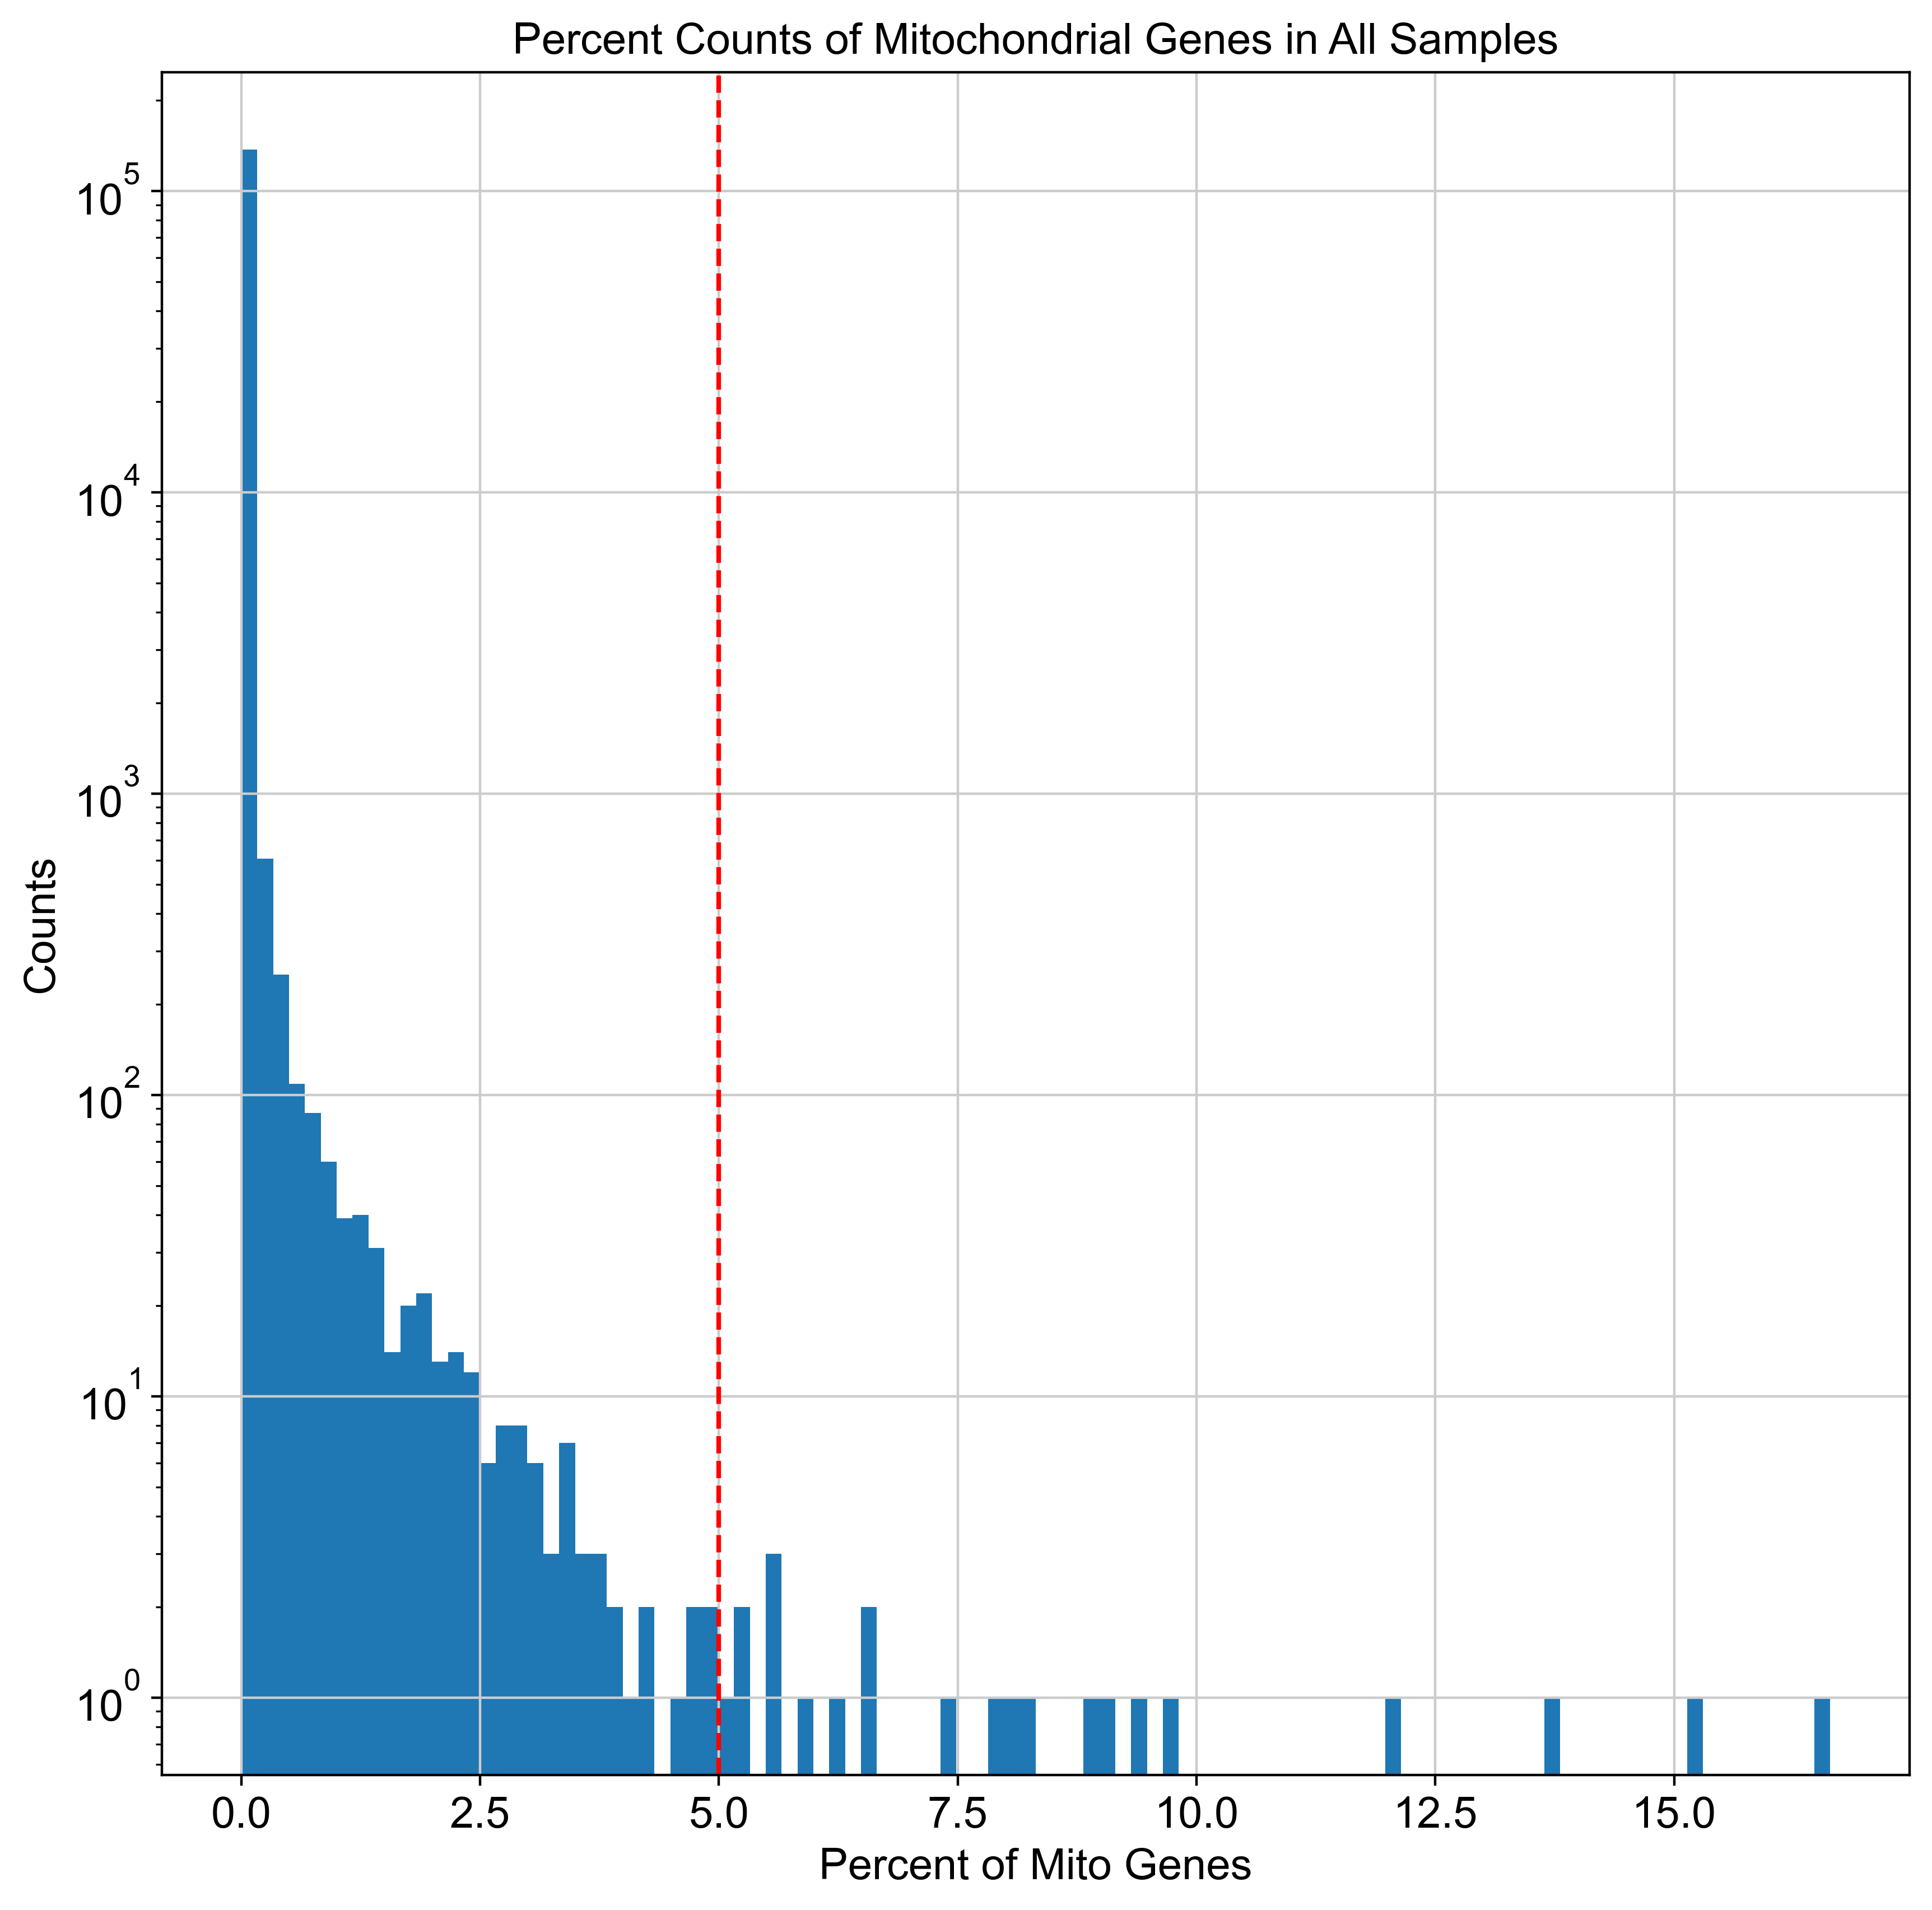

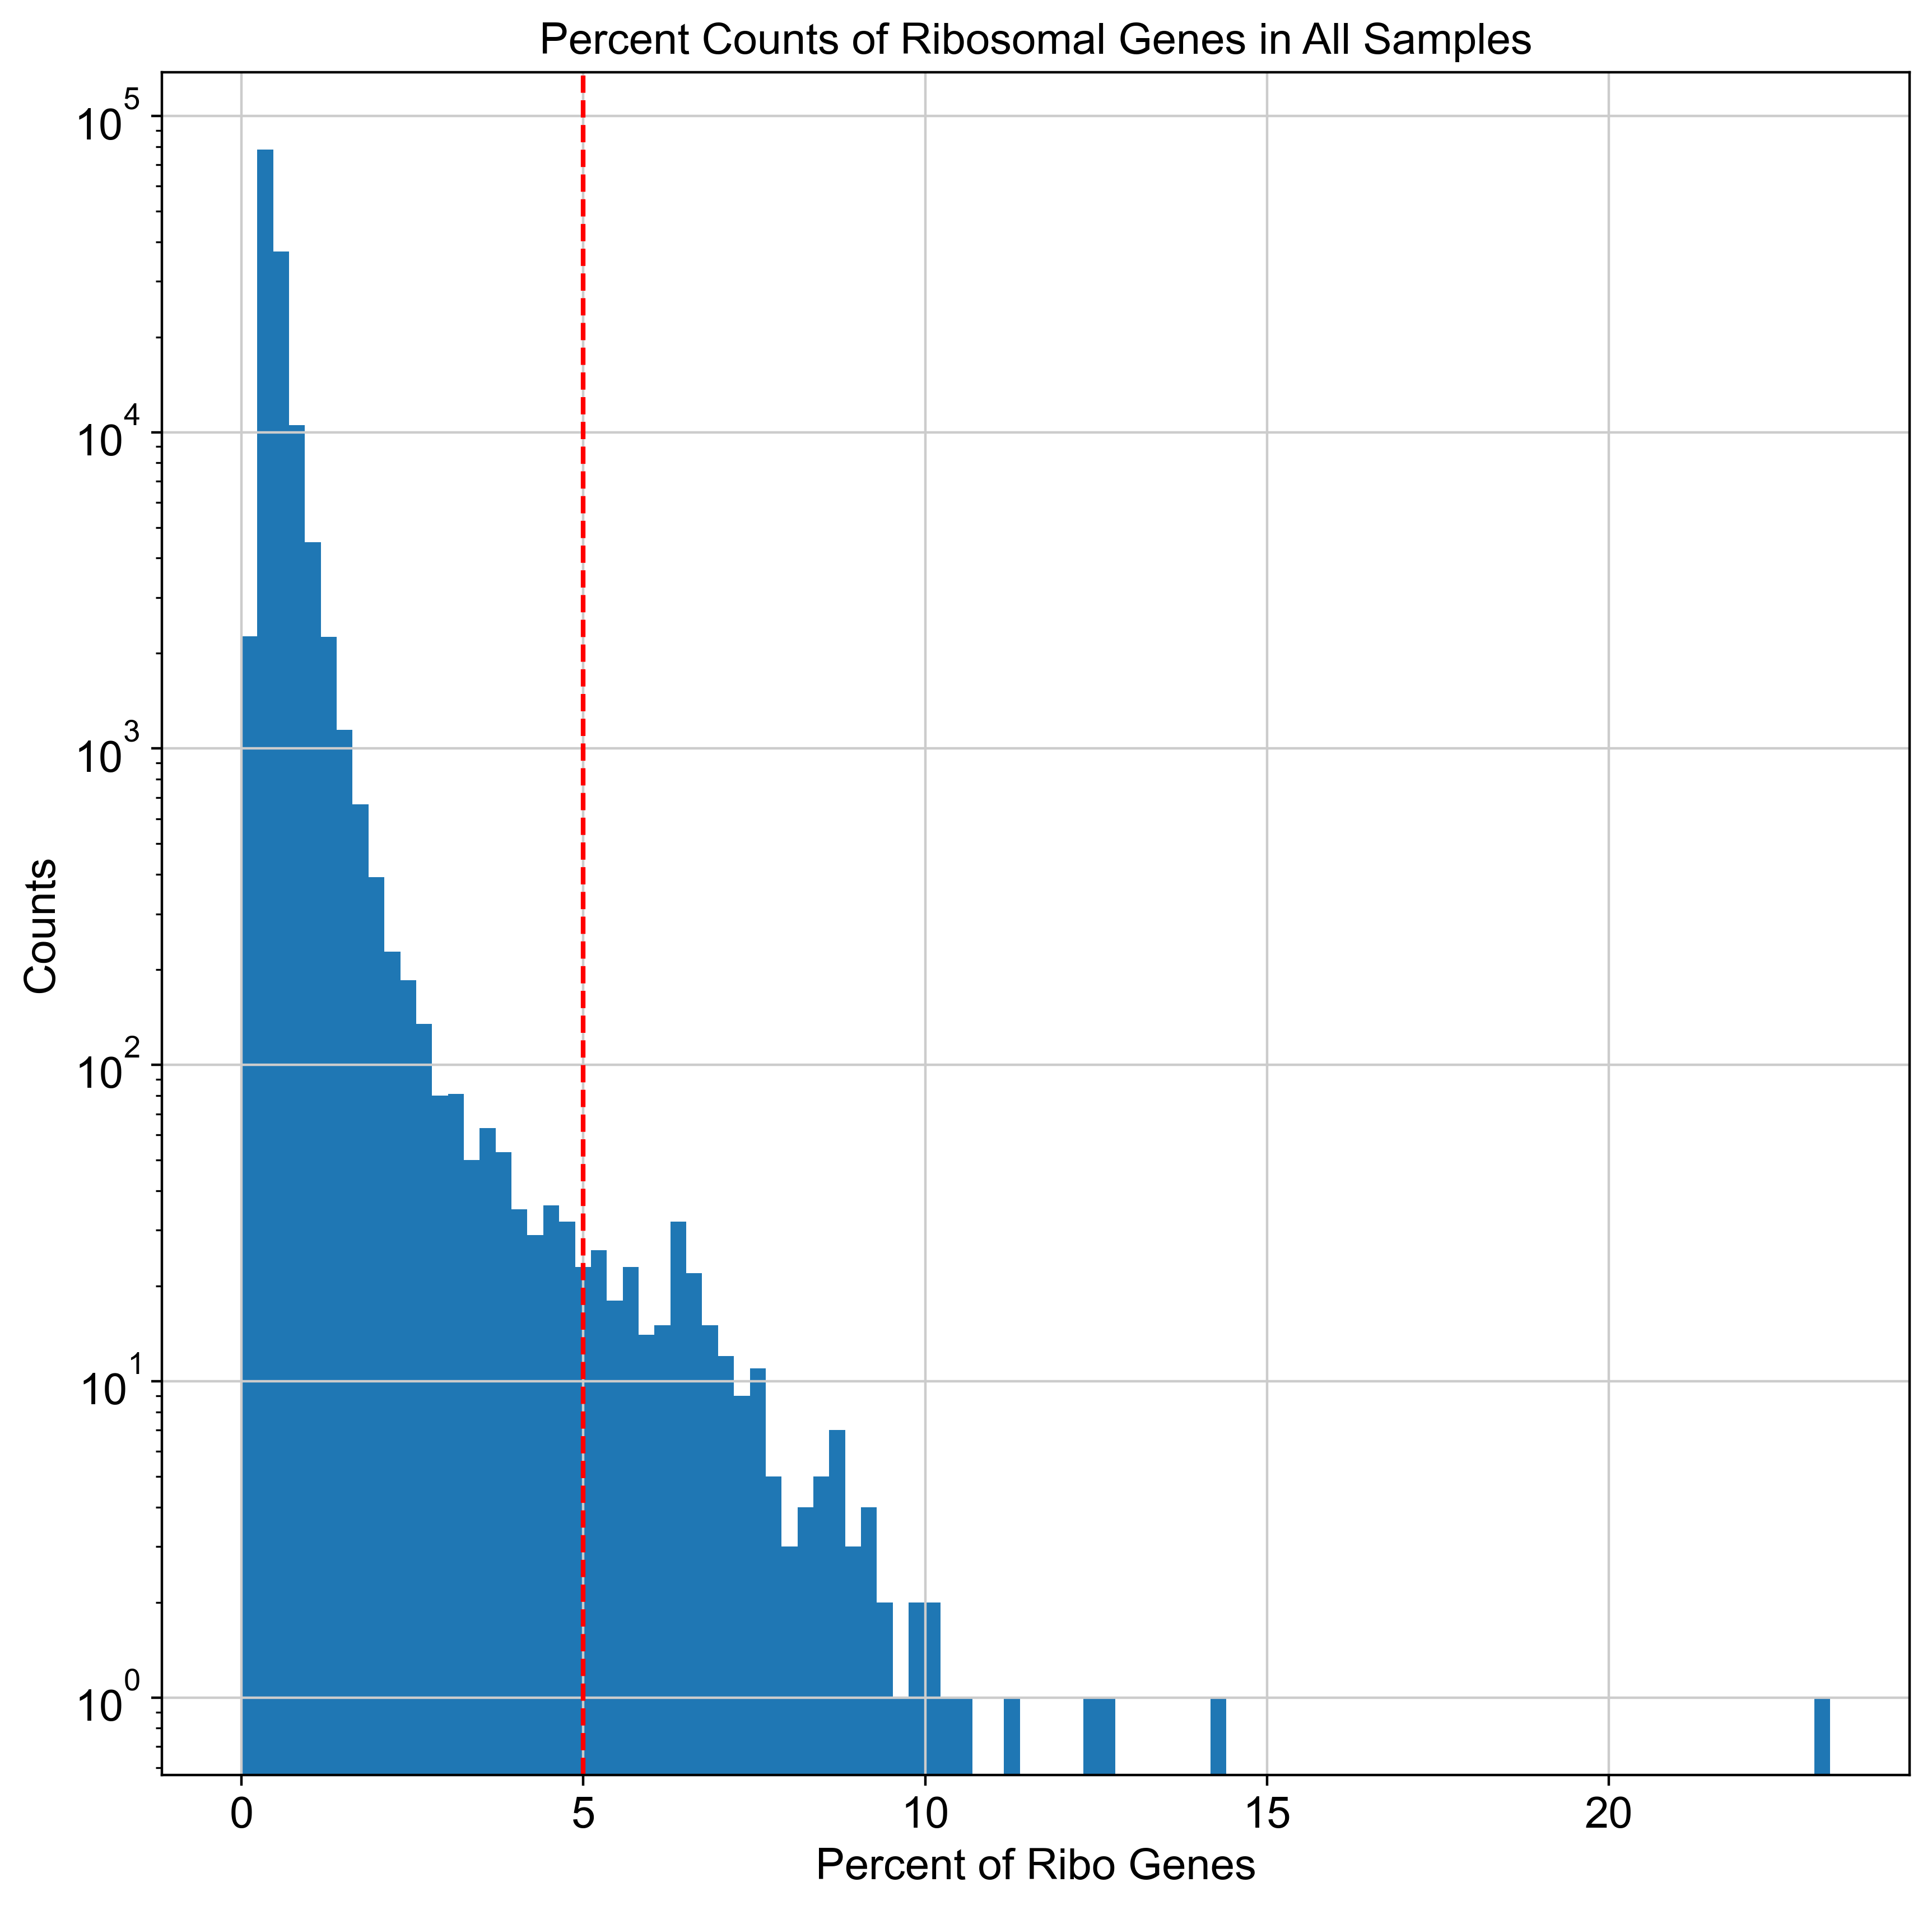

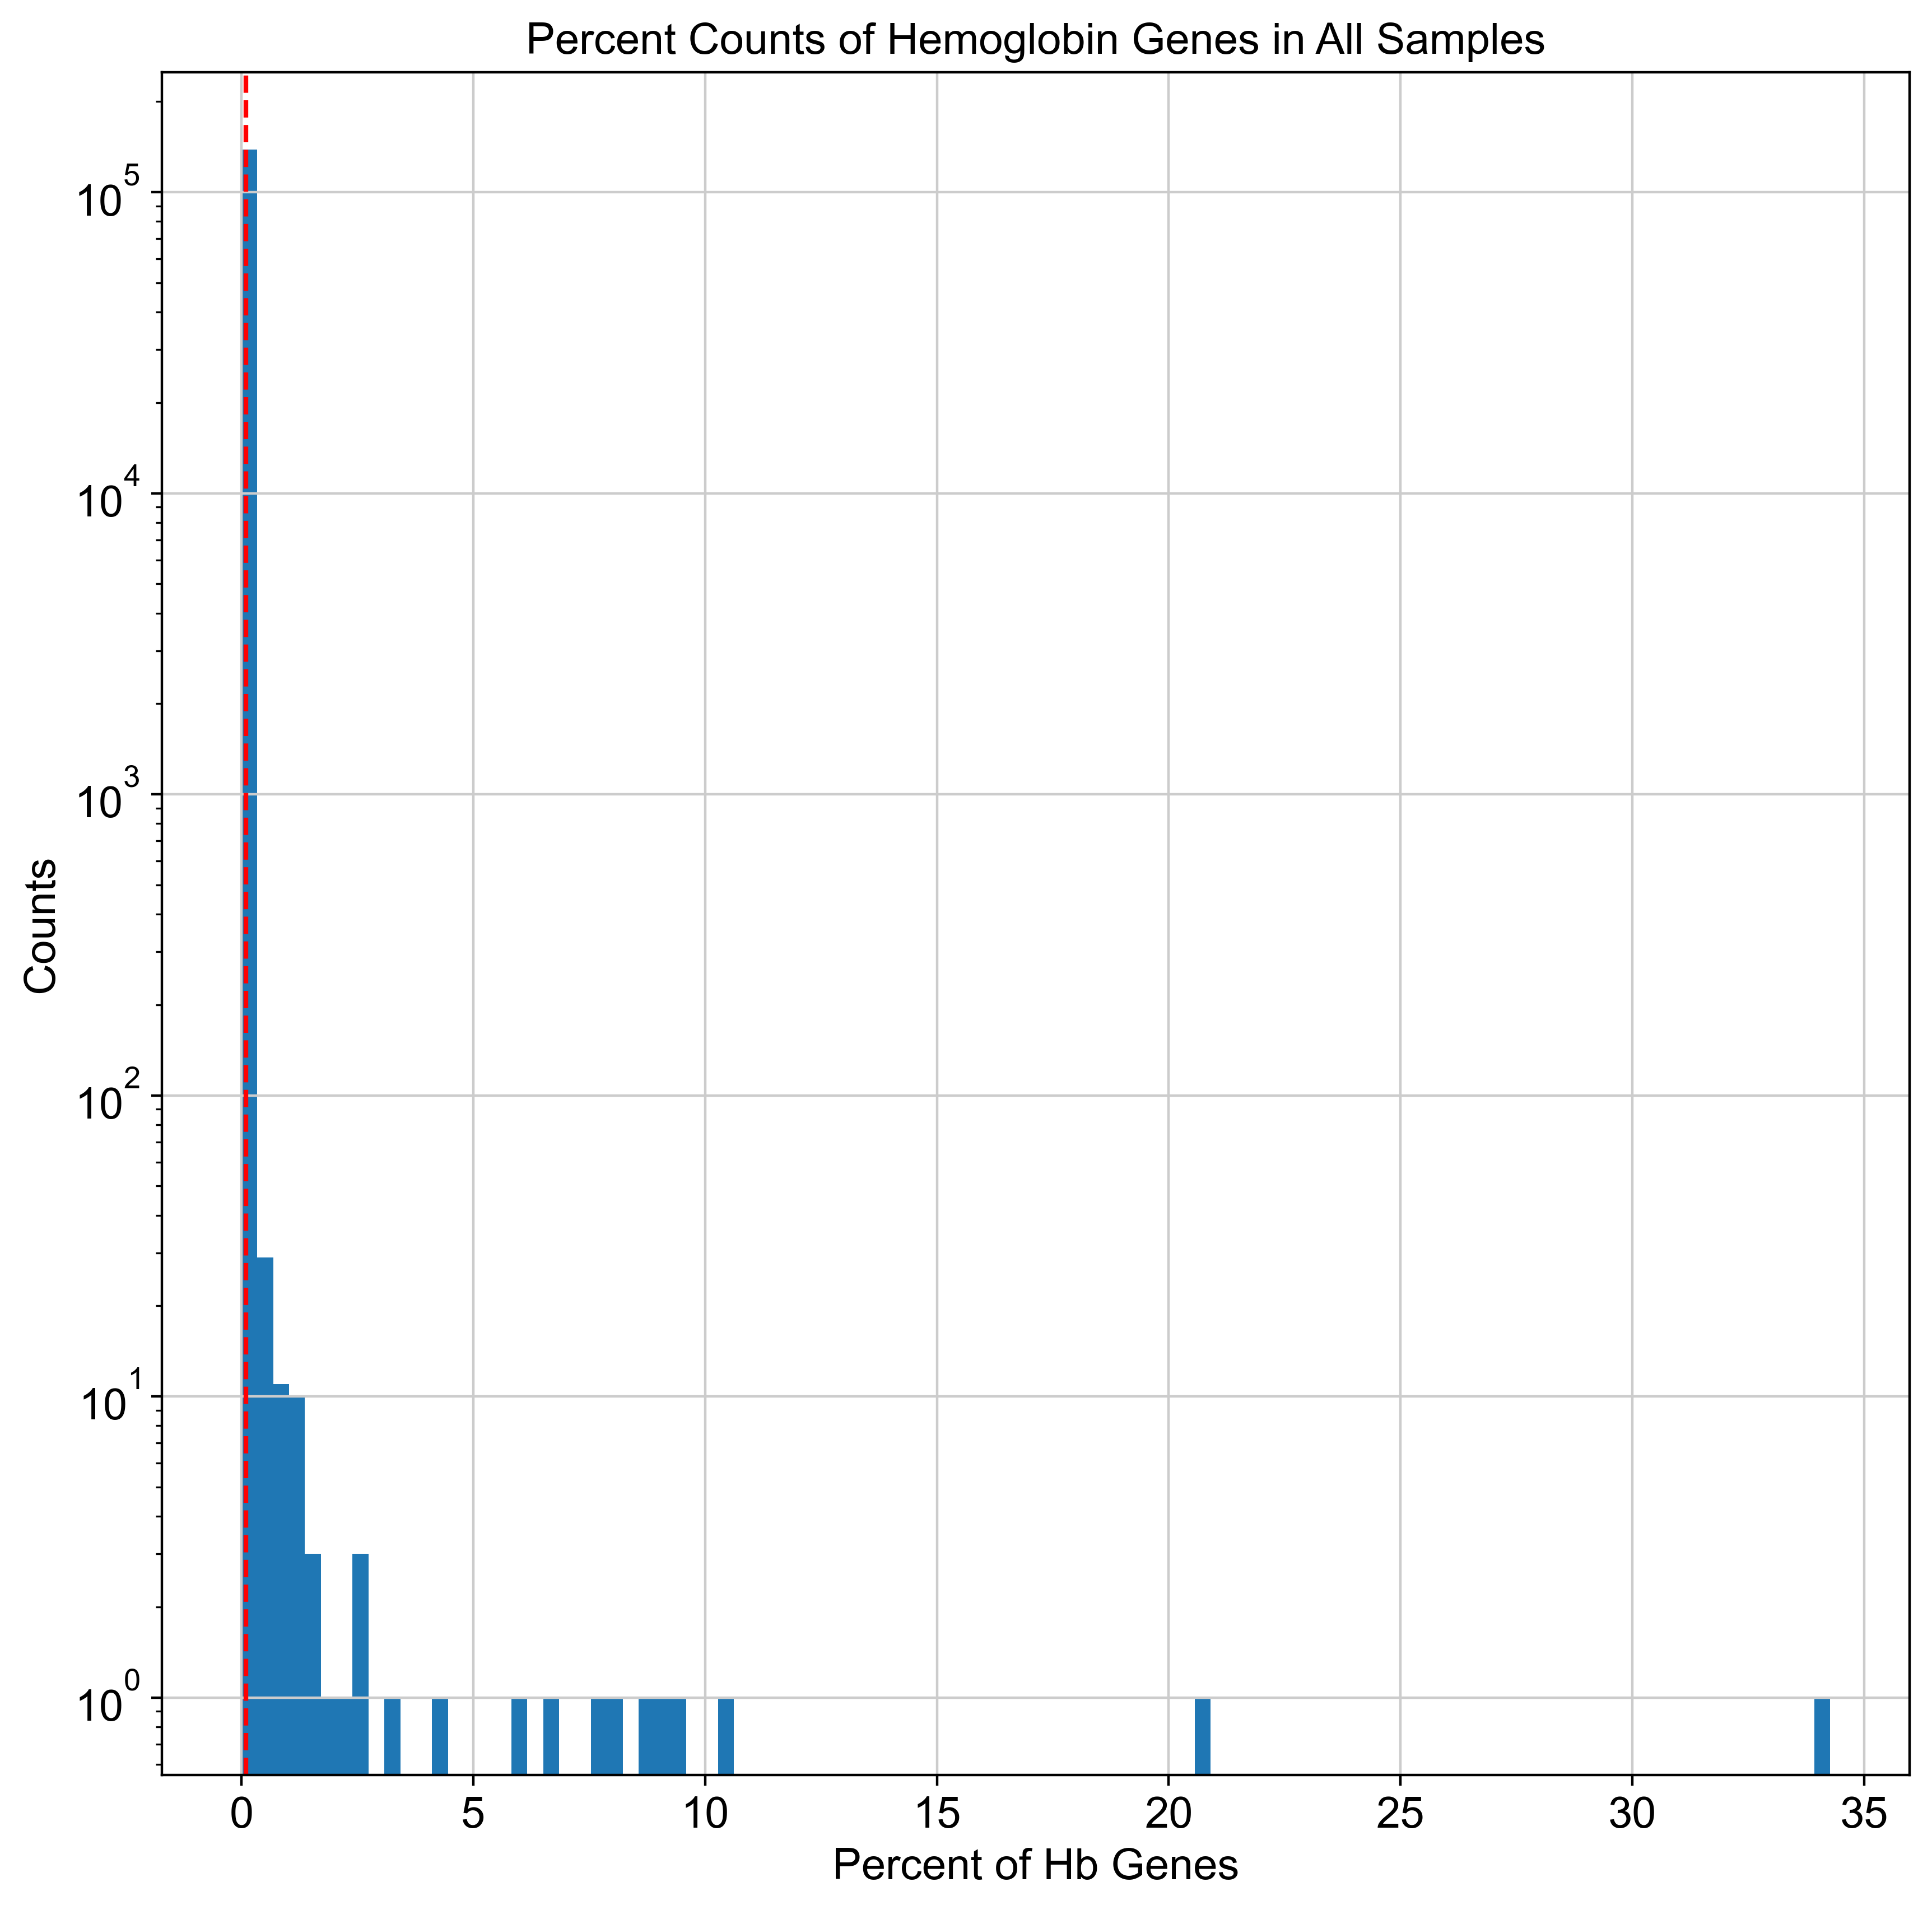

In [15]:
'''PRE-FILTER HISTOGRAMS OF PERCENT MT, RB, AND HB GENES'''

histFilterPlot(data, 'pct_counts_mt', 5, True, 100, 'Percent of Mito Genes', 'Counts', 
               'Percent Counts of Mitochondrial Genes in All Samples')

histFilterPlot(data, 'pct_counts_ribo', 5, True, 100, 'Percent of Ribo Genes', 'Counts', 
               'Percent Counts of Ribosomal Genes in All Samples')

histFilterPlot(data, 'pct_counts_hb', 0.1, True, 100, 'Percent of Hb Genes', 'Counts', 
               'Percent Counts of Hemoglobin Genes in All Samples')

In [16]:
'''REMOVING NUCLEI WITH MT, RB, AND HB PERCENTS GREATER THAN THRESHOLD'''

# filter for percent mito
data = data[data.obs['pct_counts_mt'].values < 5] 
print('Number of Nuclei After Mt Filter: {:d}'.format(data.n_obs))

# filter for percent ribo
data = data[data.obs['pct_counts_ribo'].values < 5] 
print('Number of Nuclei After Ribo Filter: {:d}'.format(data.n_obs))

# filter for percent hemoglobin 
data = data[data.obs['pct_counts_hb'].values < 0.1]
print('Number of Nuclei After Hb Filter: {:d}'.format(data.n_obs))


Number of Nuclei After Mt Filter: 138541
Number of Nuclei After Ribo Filter: 138296
Number of Nuclei After Hb Filter: 137875


In [17]:
'''REMOVING MT, RB, AND HB GENES'''

# Creating a list with the Mt, Rb, and Hb Genes
mito_genes = data.var_names.str.startswith(mitoPrefixes)
rb_genes = data.var_names.str.startswith(riboPrefixes)
hb_genes = data.var_names.str.startswith(hbPrefixes)
malat1 = data.var_names.str.startswith('Malat1')

# Removes MALAT1, ribo genes, mito, and hb genes
remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
remove = np.add(remove, rb_genes)

keep = np.invert(remove)

data = data[:,keep]

print('Number of Genes After Removing Mt, Rb, and Hb Genes: {:d}'.format(data.n_vars))

Number of Genes After Removing Mt, Rb, and Hb Genes: 32086


### Min. Genes Filter

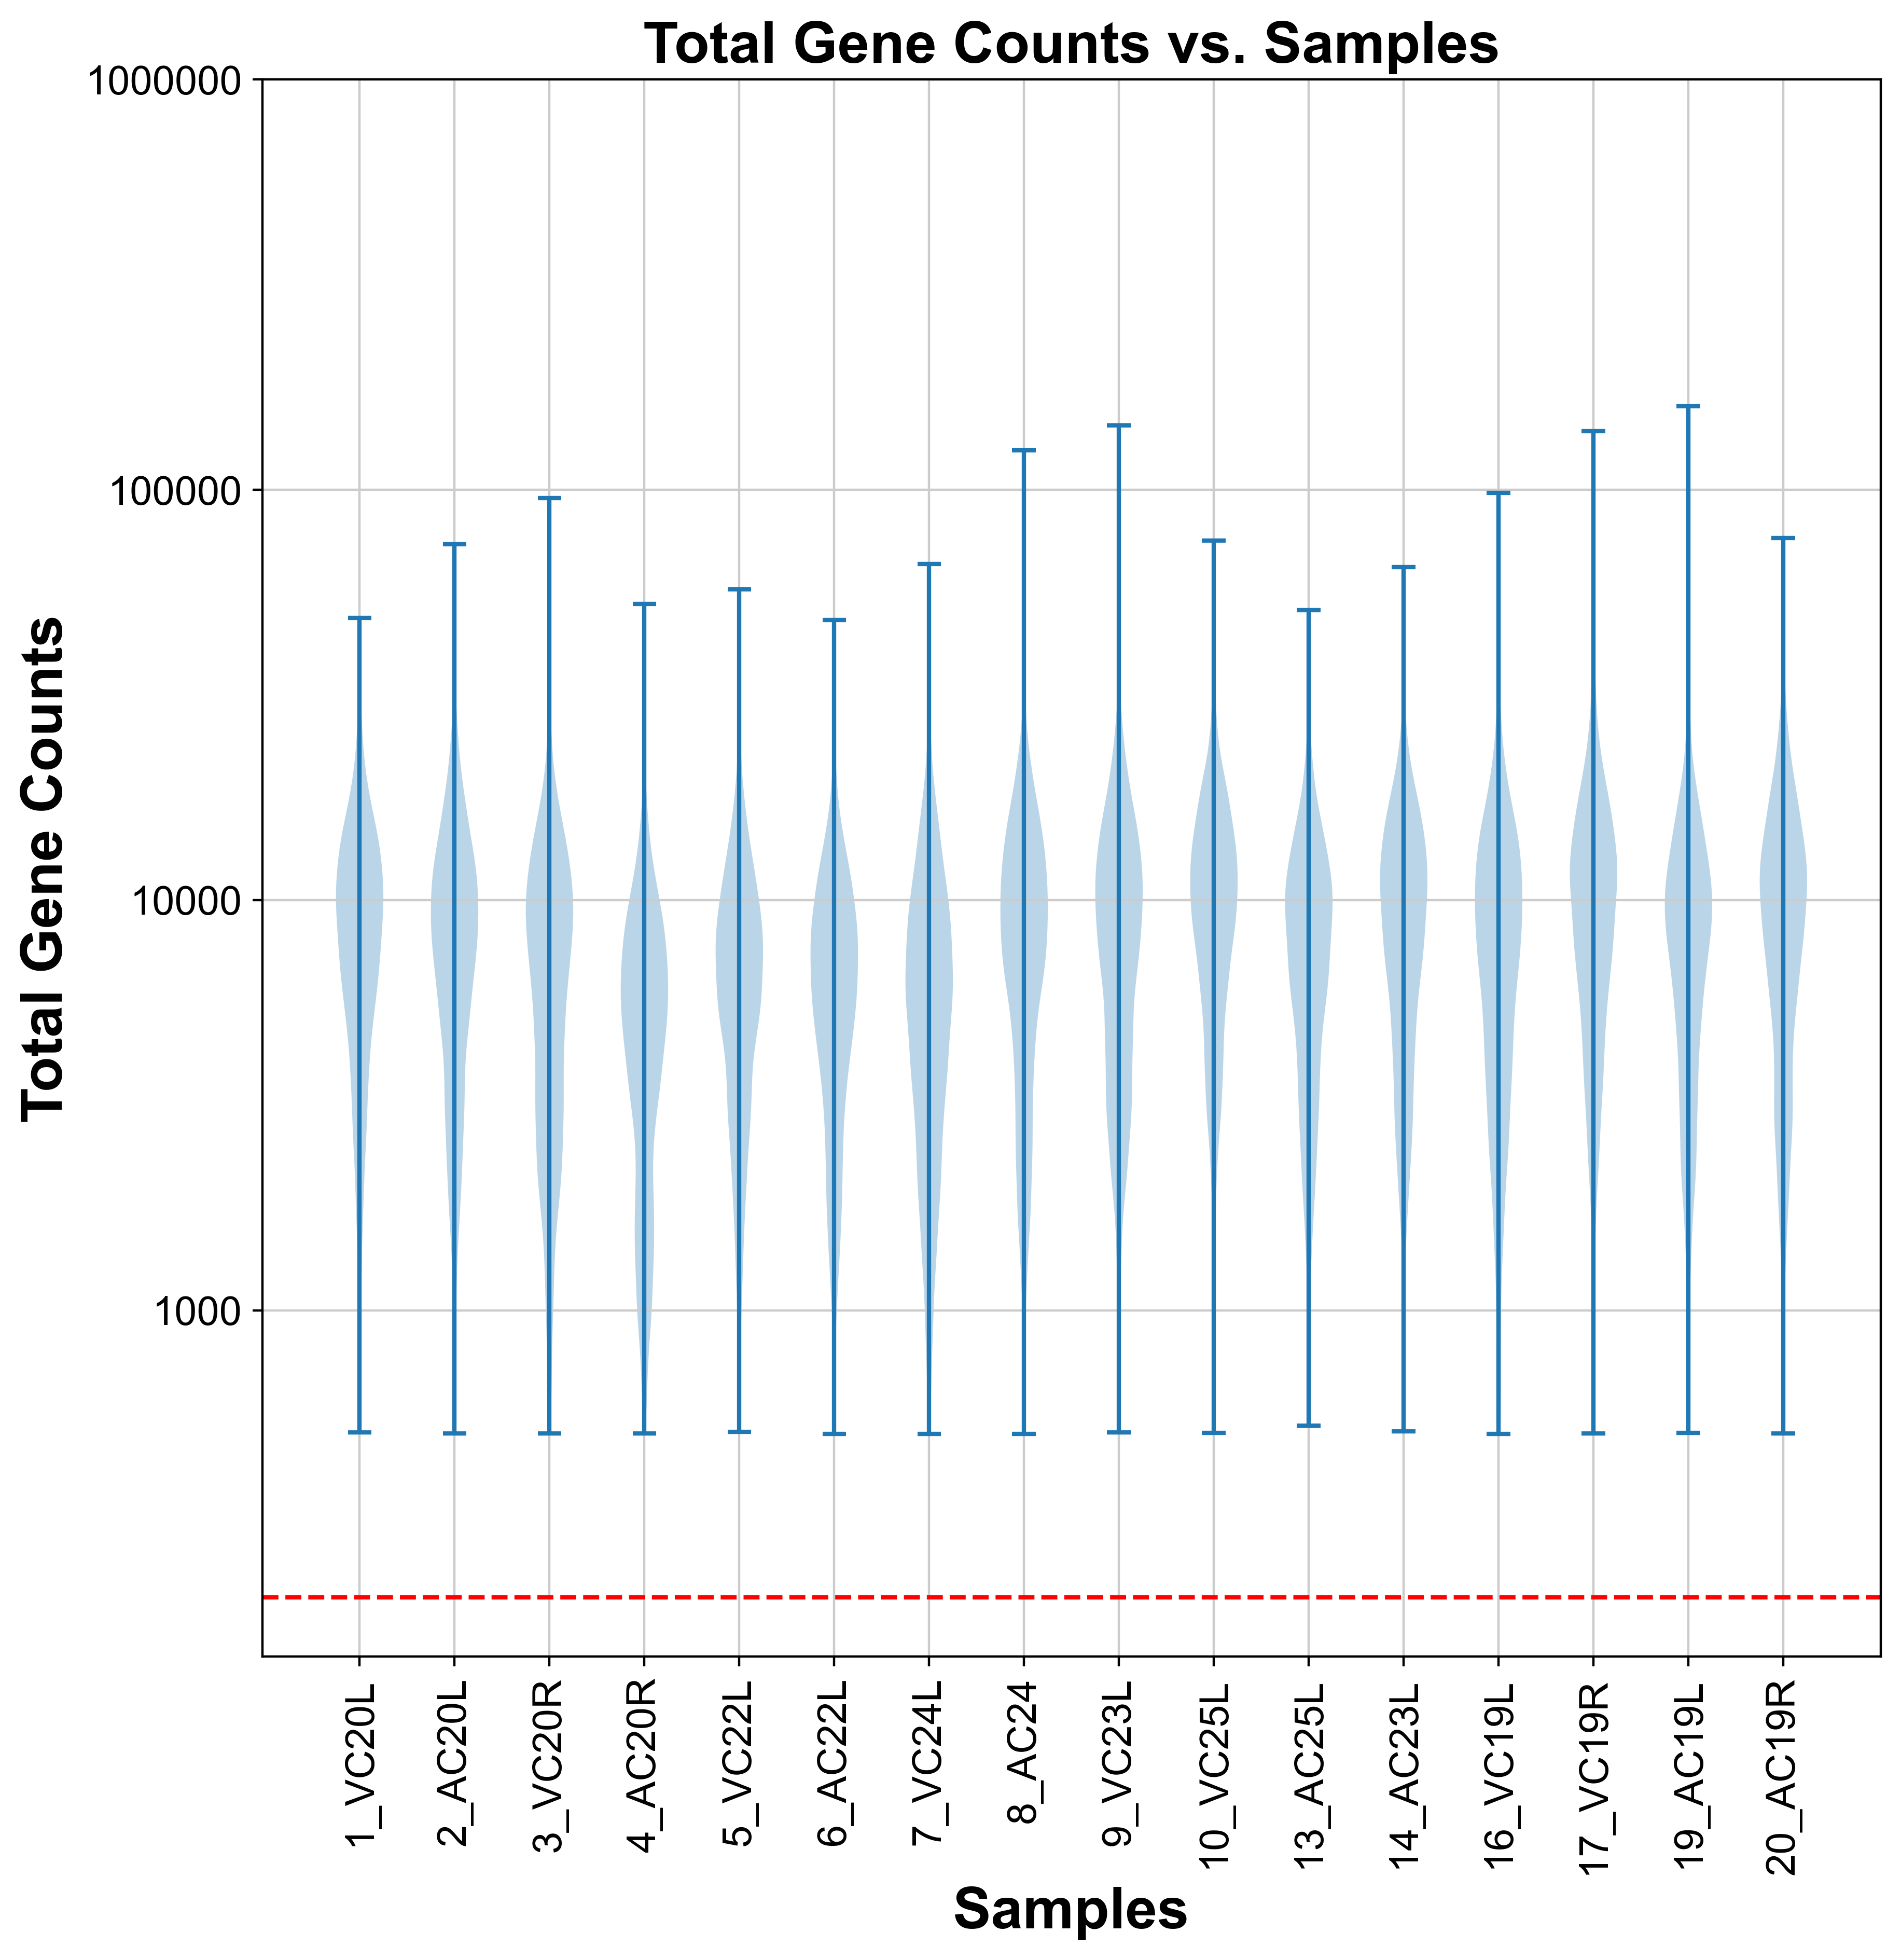

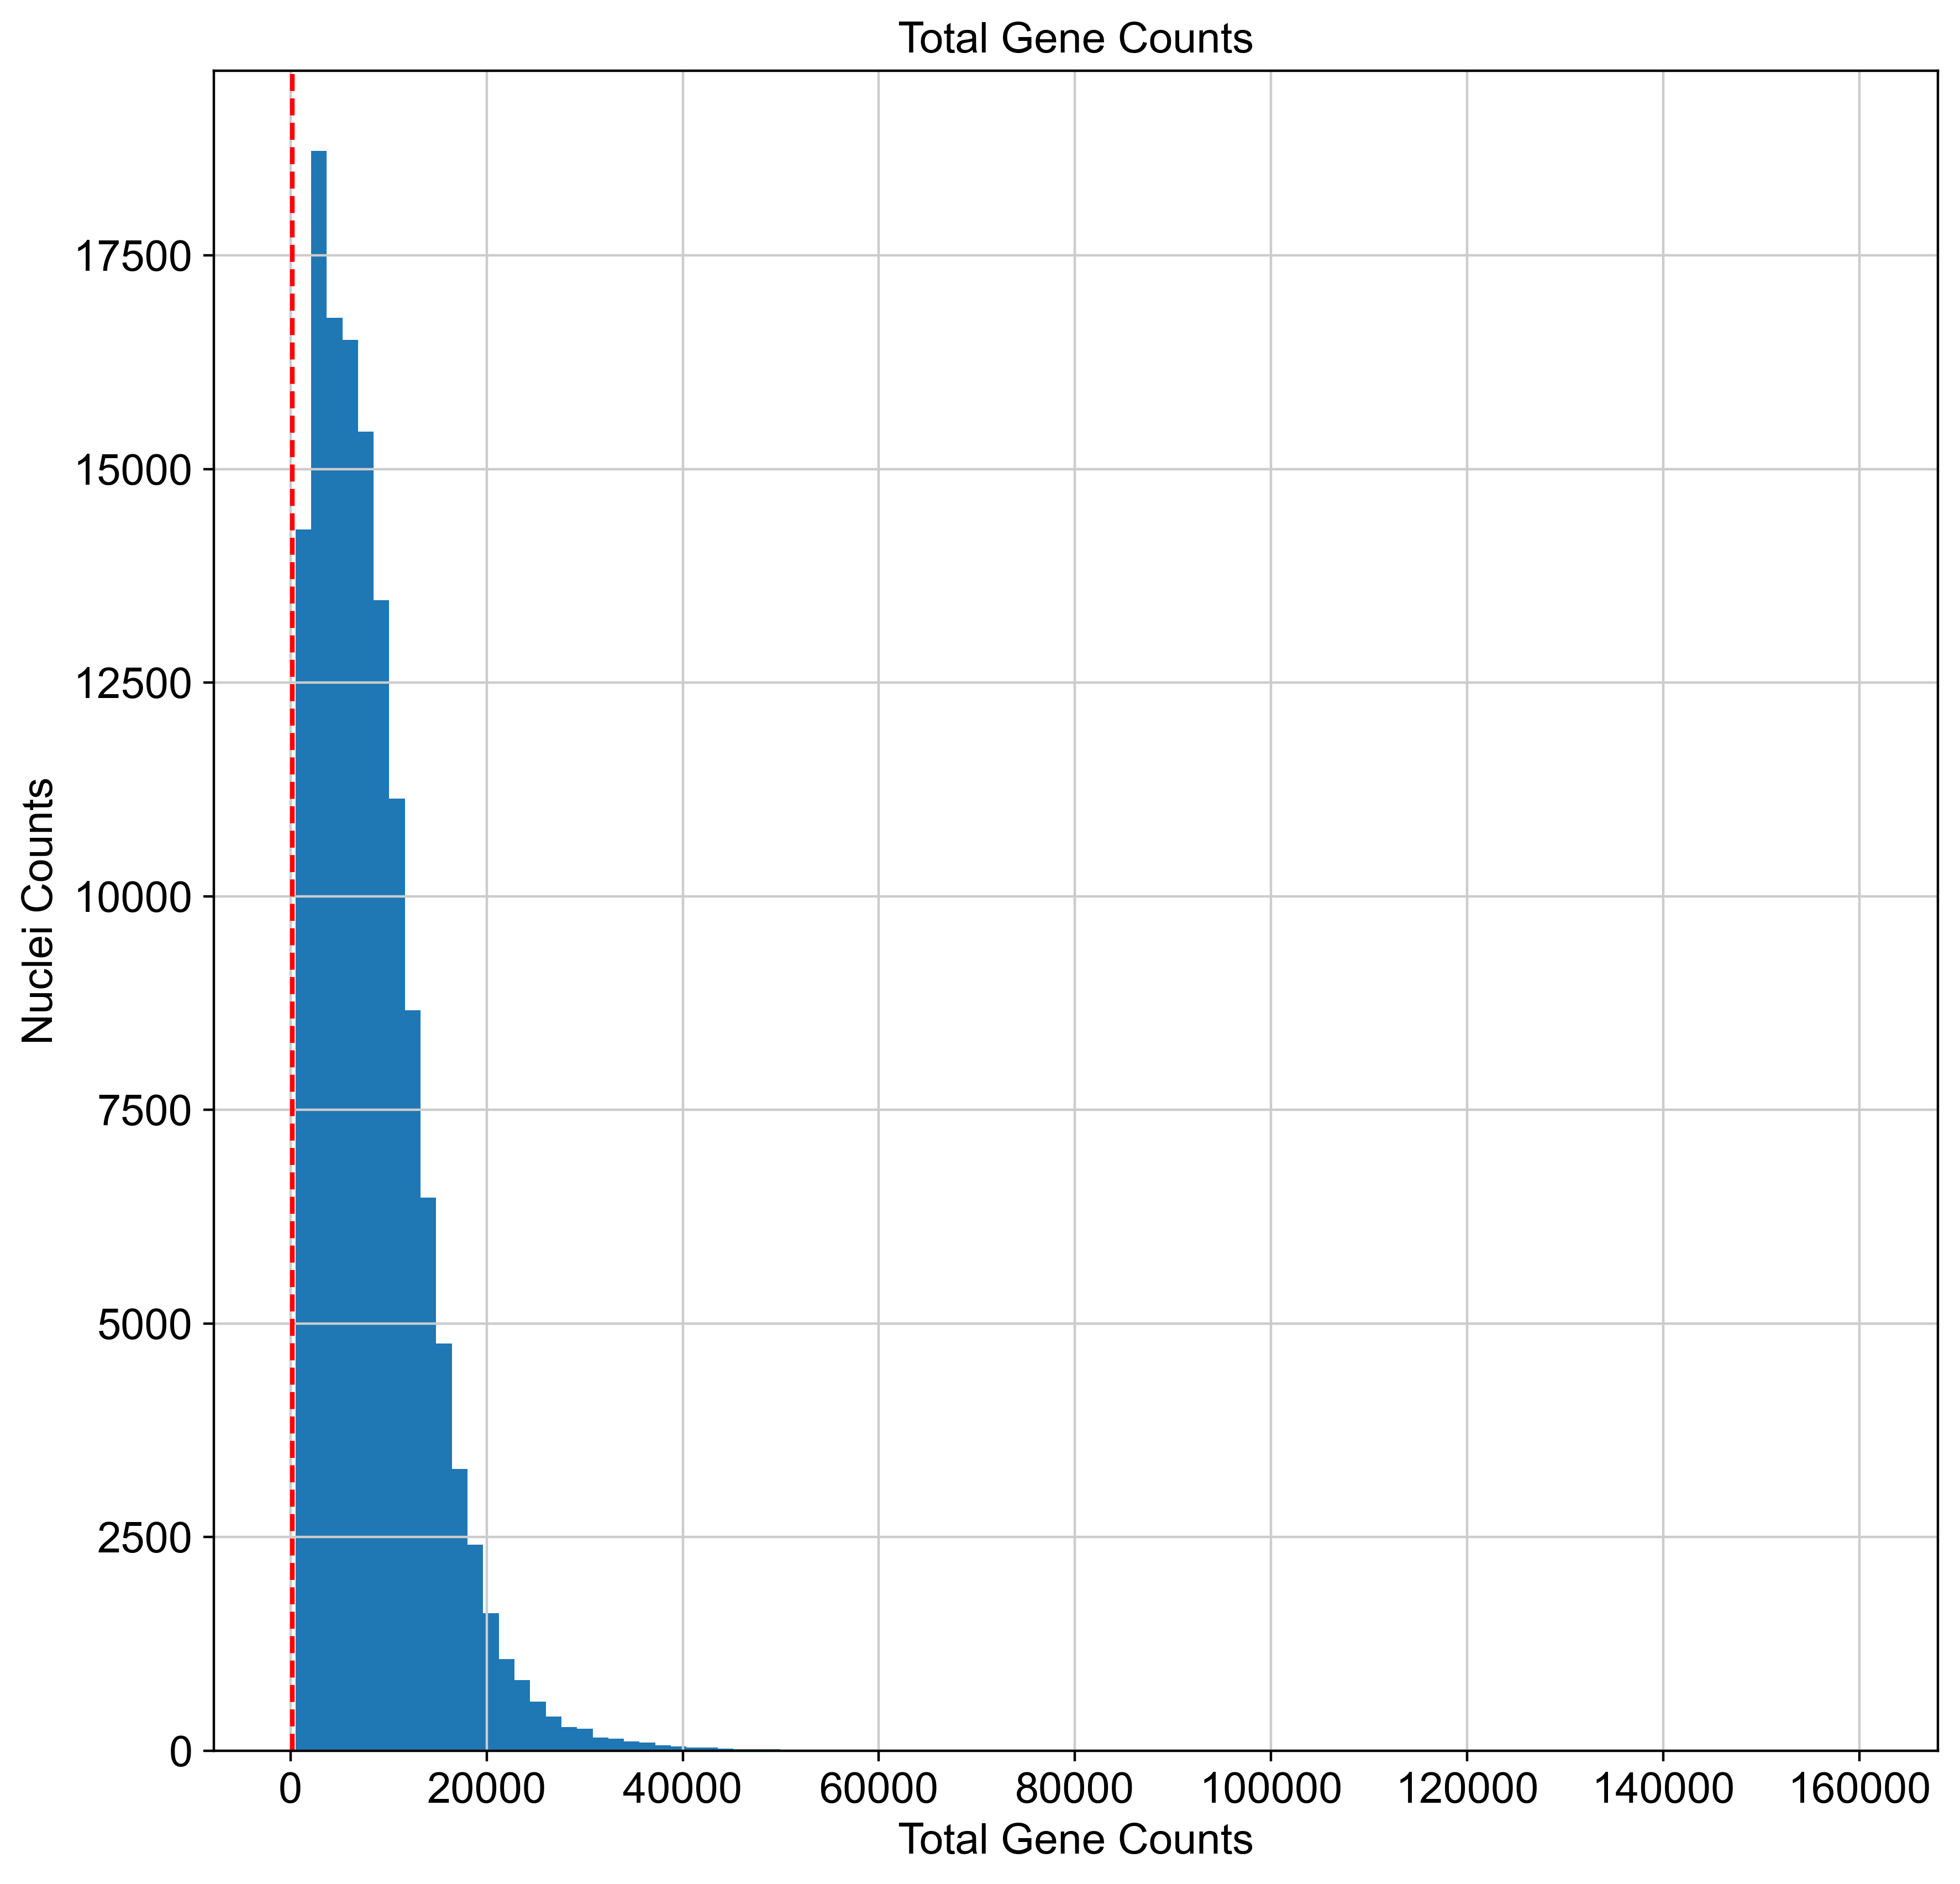

In [18]:
'''MIN GENE FILTER PLOTS'''

violinFilterPlot(data, 'total_counts', 2.30102999566, [3, 4, 5, 6], [1000, 10000, 100000, 1000000], 
               'Total Gene Counts')

histFilterPlot(data, 'total_counts', 200, False, 100, 'Total Gene Counts', 'Nuclei Counts', 
               'Total Gene Counts')

In [19]:
'''TABLE SHOWS THE NUCLEI WITH THE LEAST NUMBER OF GENE COUNTS PER SAMPLE'''

# Get the minimum number of genes per sample
min_genes_per_sample = data.obs.groupby('sample')['total_counts'].min()

# Get the nuclei with the minimum number of genes per sample
min_genes_nuclei = data.obs.loc[data.obs.groupby('sample')['total_counts'].idxmin()]

# Create a table using pandas DataFrame
table = pd.DataFrame({
    'Sample': min_genes_nuclei['sample'],
    'Min Genes': min_genes_nuclei['total_counts']})

# Display the table
print(table)

                         Sample  Min Genes
CTCCTCCTCGGTGCAC-1-0    1_VC20L      504.0
ACGTCCTCAACGTTAC-1-1    2_AC20L      502.0
AGGTAGGTCGCTAATG-1-2    3_VC20R      501.0
GGTGTCGGTAGTCGGA-1-3    4_AC20R      501.0
GTAACCAAGCGTTCCG-1-4    5_VC22L      505.0
TTCAATCGTTGGTACT-1-5    6_AC22L      500.0
AGTAACCTCCGTCACT-1-6    7_VC24L      500.0
AGGGCCTCAAGTCGTT-1-7     8_AC24      500.0
CCGGGTAGTGGTAACG-1-8    9_VC23L      504.0
GAAGCCCGTCGTGATT-1-9   10_VC25L      503.0
GCCCGAAAGCTGACCC-1-11  13_AC25L      523.0
CCCGAAGCAATCGCGC-1-12  14_AC23L      507.0
AGAAGTAGTCATCACA-1-13  16_VC19L      500.0
ACACGCGTCCAAGAGG-1-14  17_VC19R      501.0
ACTCTCGCAAATGCTC-1-16  19_AC19L      503.0
TCCCACATCAGTCACA-1-17  20_AC19R      501.0


In [20]:
'''MIN GENES FILTER'''

sc.pp.filter_cells(data, min_genes = 200)
#sc.pp.filter_cells(adata, max_genes = 5000) # UNCOMMENT TO USE A MAX GENES FILTER

print('Number of Genes After Min. Genes Filter: {:d}'.format(data.n_vars))

C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Number of Genes After Min. Genes Filter: 32086


### Doublets Filter 

In [30]:
'''CALCULATING DOUBLETS PER SAMPLE'''

# Initializing the columns where the doublet data will be stored in the AnnData object
data.obs['doublet_scores'] = 'Nan'
data.obs['predicted_doublets'] = 'Nan'

for sample in data.obs['sample'].unique():
    # Subset the AnnData object for the current sample
    sampleObj = data[data.obs['sample'] == sample].copy()

    # Create a Scrublet object
    scrub = scr.Scrublet(sampleObj.X)

    # Run the doublets identification
    doublet_scores, predicted_doublets = scrub.scrub_doublets()

    # Add the doublet scores and predicted doublets as a new observation annotation
    sampleObj.obs['doublet_scores'] = doublet_scores.astype(str)
    sampleObj.obs['predicted_doublets'] = predicted_doublets.astype(str)
    
    # Getting doublet info to add to the AnnData Obj
    sampleBarcodeLst = list(sampleObj.obs['barcode'])
    sampleDoubletScoresLst = list(sampleObj.obs['doublet_scores'])
    samplePredictedDoubletsLst = list(sampleObj.obs['predicted_doublets'])
    
    for barcode, doubletScore, predictedDoublet in zip(sampleBarcodeLst, sampleDoubletScoresLst, samplePredictedDoubletsLst):
        # Finding the row where the doublet score and the predicted doublet info should go
        rowIndex = data.obs.index[(data.obs['barcode'] == barcode)].tolist()[0]
        
        # Adding data to the row 
        data.obs.loc[rowIndex, 'doublet_scores'] = doubletScore
        data.obs.loc[rowIndex, 'predicted_doublets'] = predictedDoublet

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 38.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.3%
Elapsed time: 6.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 49.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.0%
Elapsed time: 6.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 43.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.3%
Elapsed time: 6.3 seconds
Preprocessing...
Simulating double

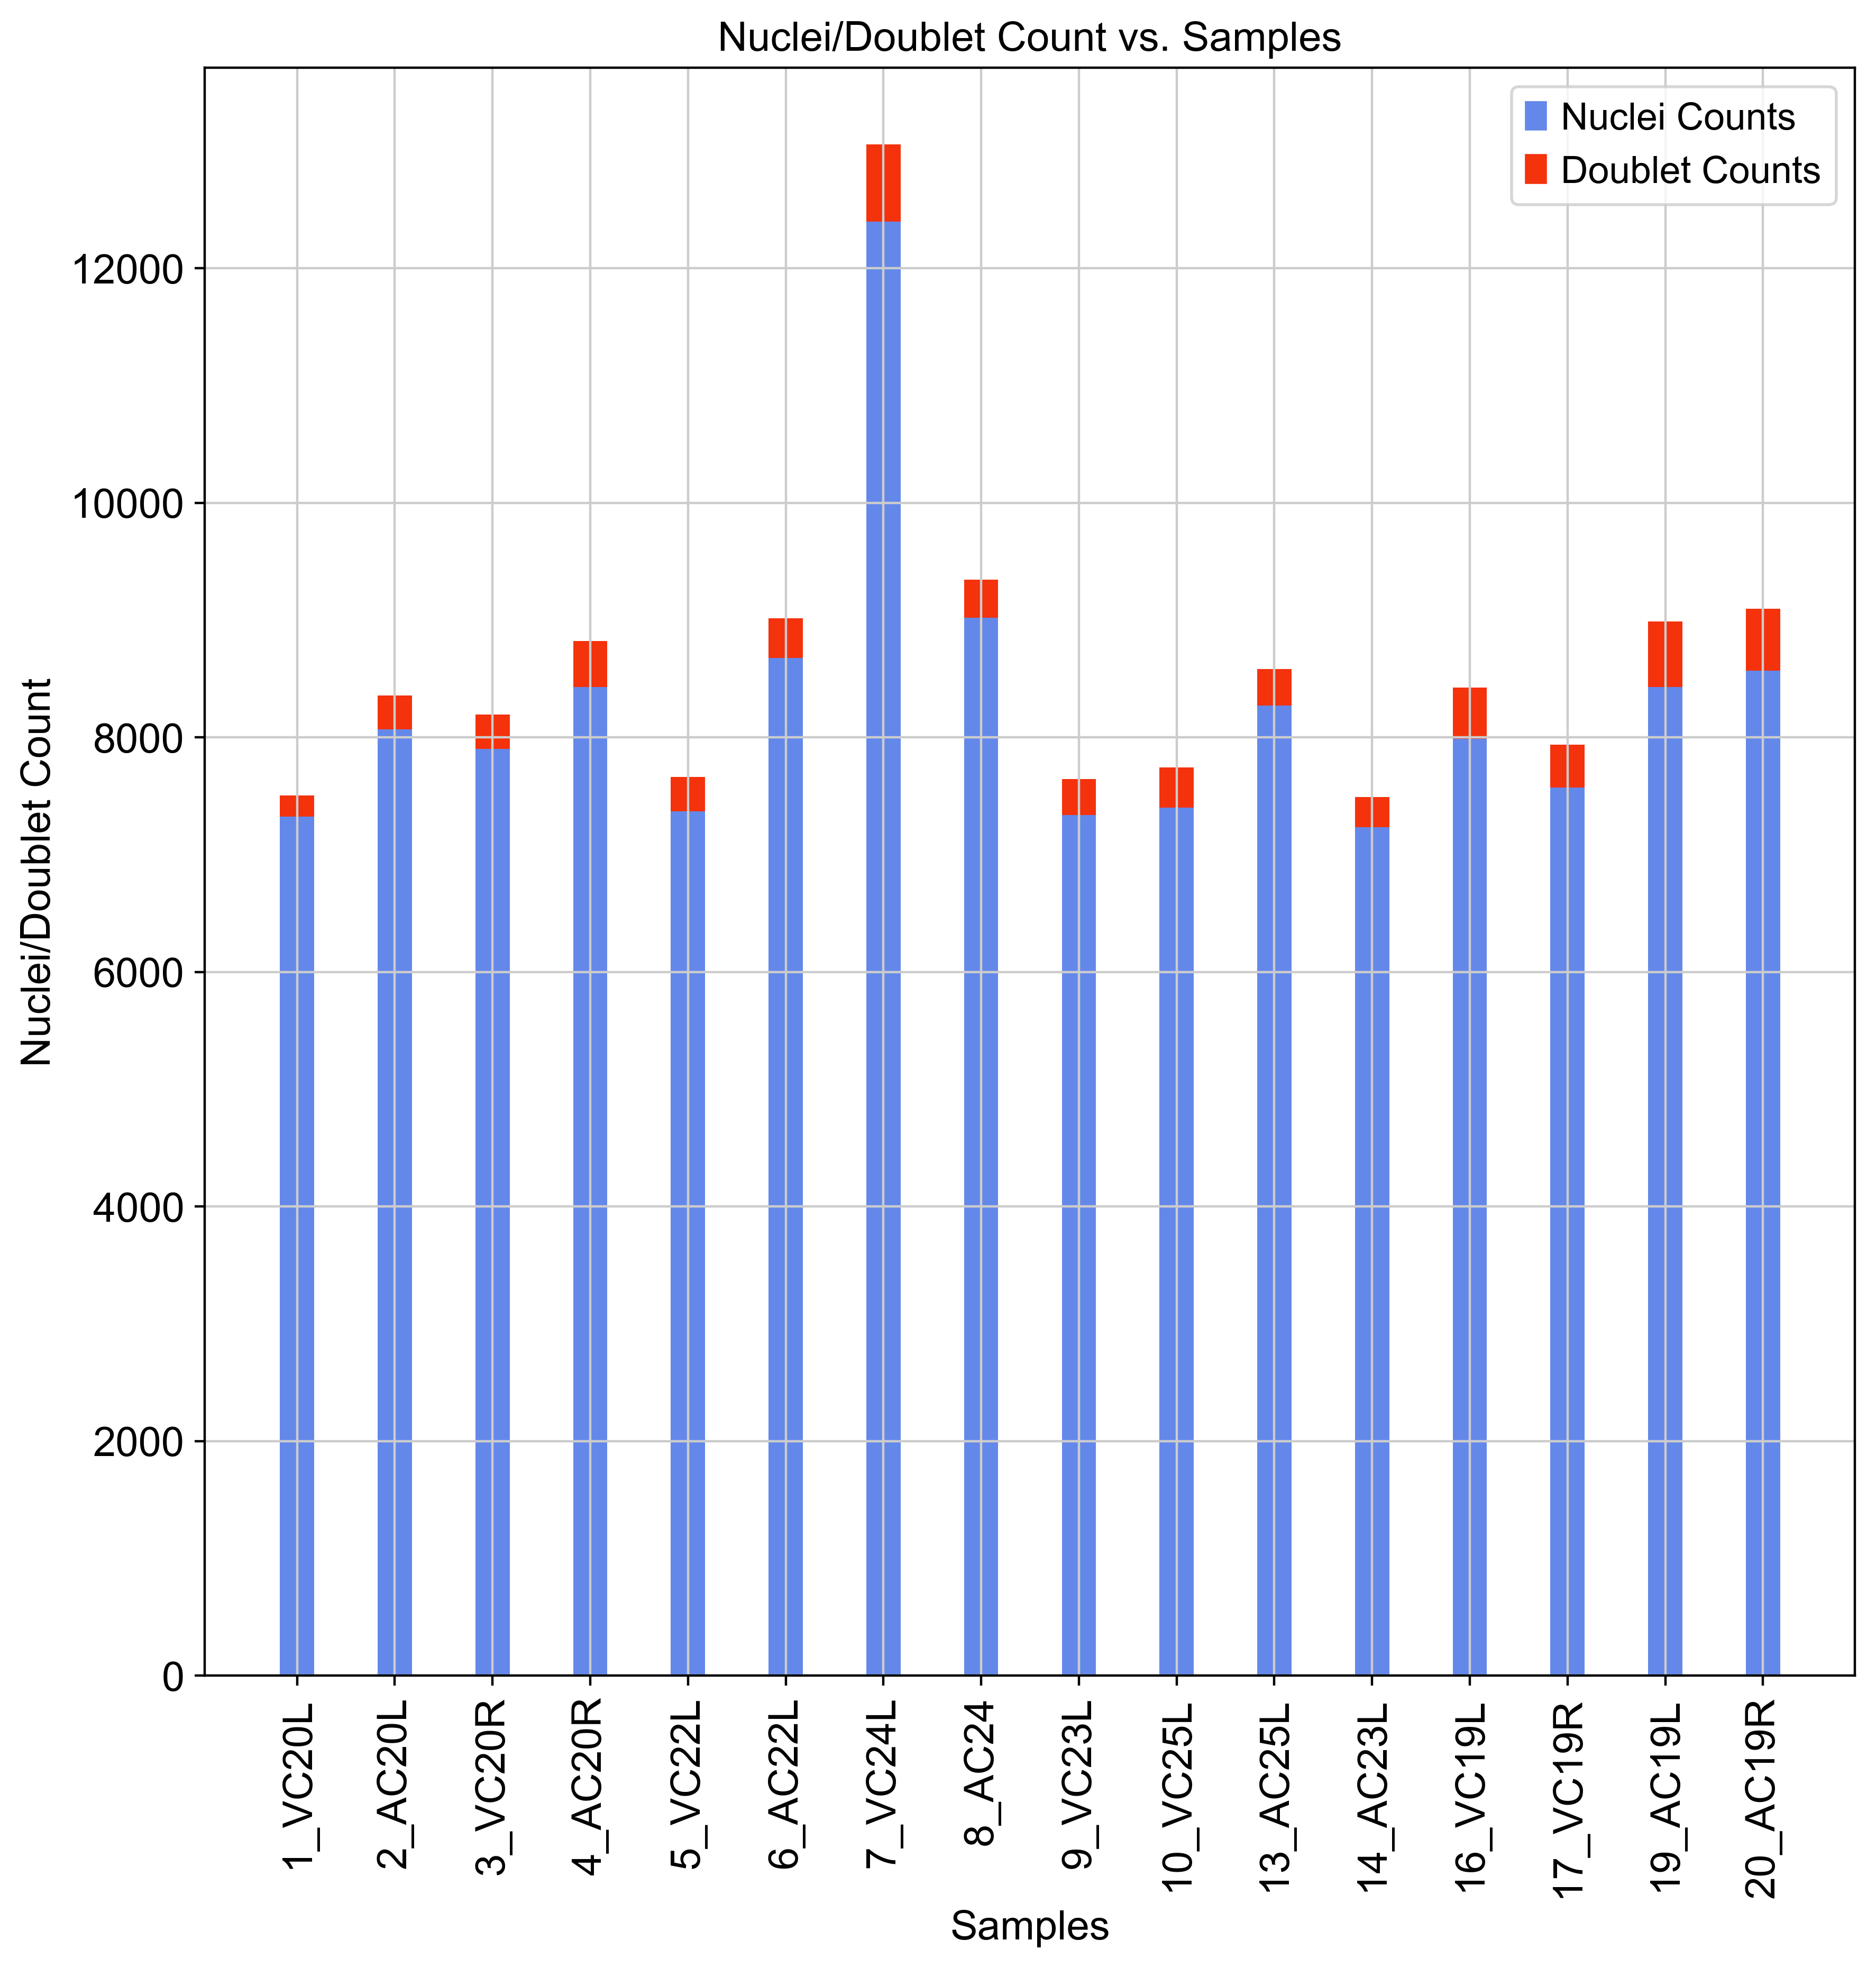

In [34]:
'''VISUALIZING THE AMOUNT OF DOUBLETS IN THE DATA'''

doubletBar(data)

In [37]:
 '''REMOVING DOUBLETS'''
    
data = data[data.obs['predicted_doublets'] == 'False',:]
print('Number of nuclei after doublet filter: {:d}'.format(data.n_obs))
print('Number of genes after doublet filter: {:d}'.format(data.n_vars))

Number of nuclei after doublet filter: 0
Number of genes after doublet filter: 32086


### Min. Cells Gene Filter

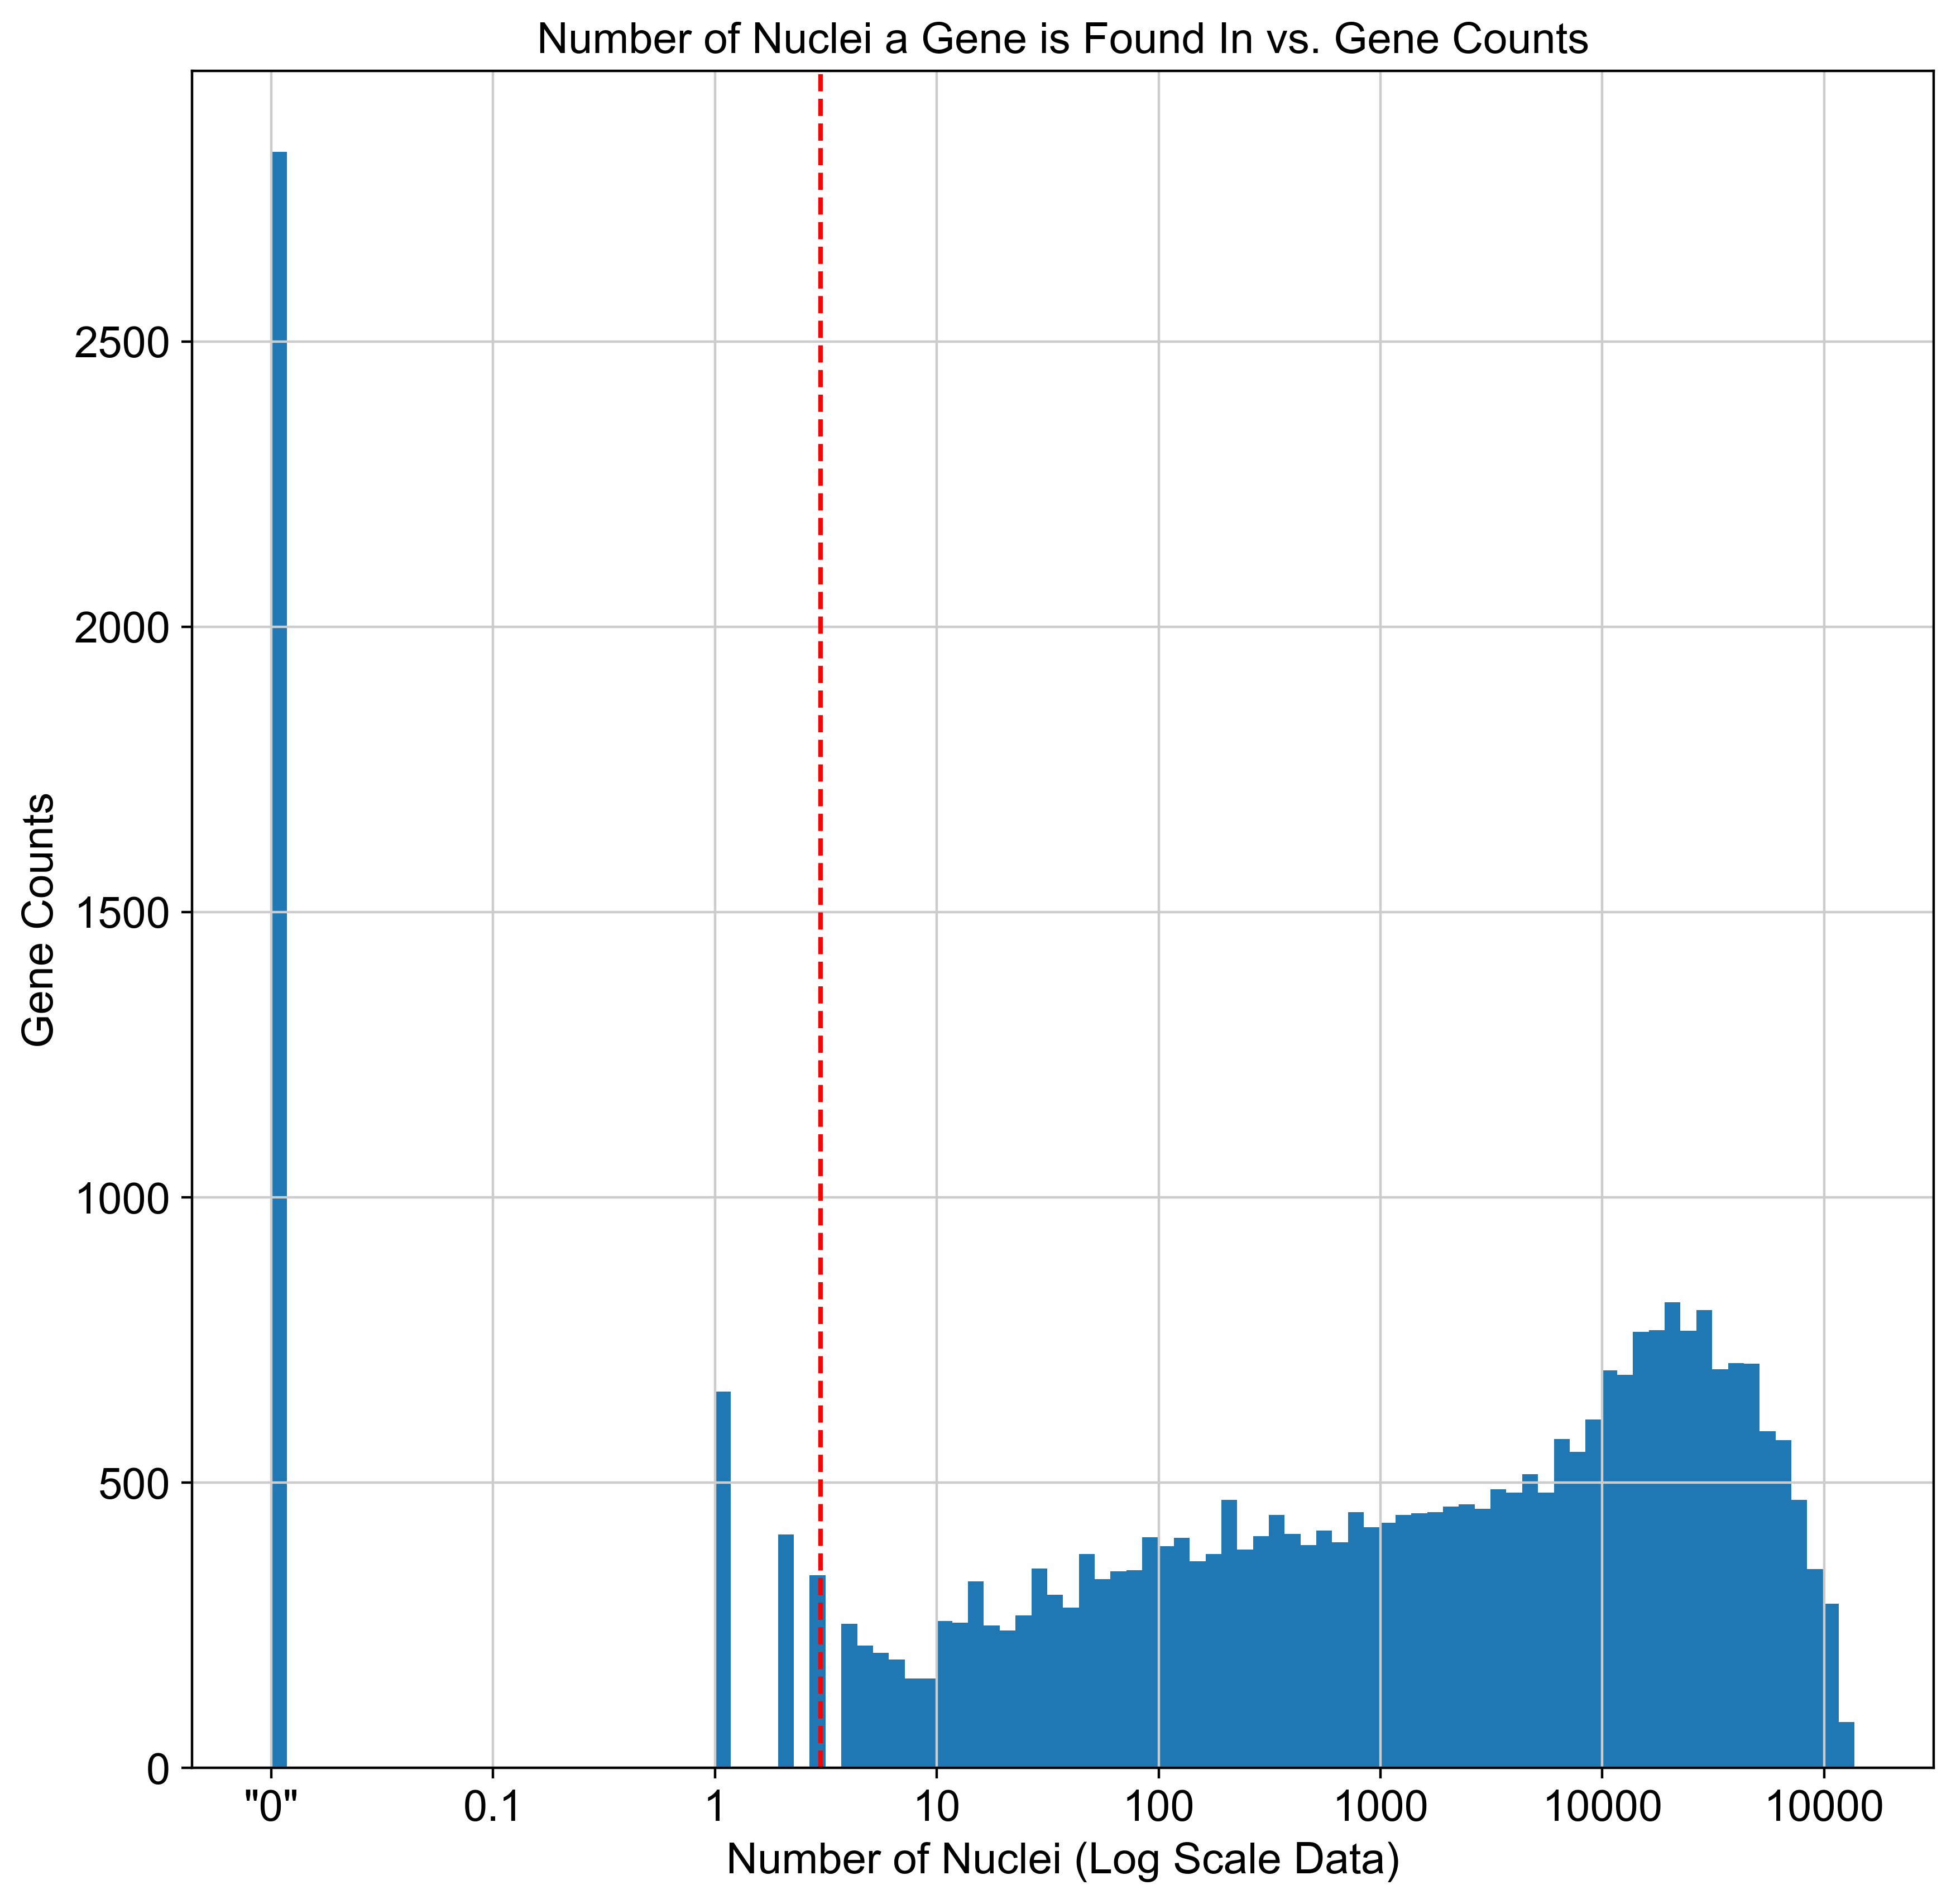

In [27]:
'''VISUALIZING THE NUMBER OF GENES FOUND IN LESS THAN 3 CELLS PRE-FILTER'''

lessThanThreeCellPlot(data)

In [27]:
'''REMOVING GENES FOUND IN LESS THAN 3 CELLS'''

#remove genes in < 3 cells
sc.pp.filter_genes(data, min_cells=3)
print('Number of nuclei after cell filter: {:d}'.format(data.n_obs))
print('Number of genes after cell filter: {:d}'.format(data.n_vars))

filtered out 3978 genes that are detected in less than 3 cells


C:\Users\Hlab\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Number of nuclei after cell filter: 131991
Number of genes after cell filter: 28108


## Checkpoint 1 - Post-Filtering Data

In [35]:
'''CREATING CHECKPOINT 1'''

# Creates the 'scanpy_mouse_FILTERED.h5ad' data file using all of the already filtered data 
save_file = 'F:/Single_Cell_Seq_Python_Git/Mouse_Preprocessing_Pipeline/scanpy_mouse_CHECKPOINT1.h5ad'
data.write_h5ad(save_file)

In [ ]:
'''LOADING CHECKPOINT 1'''

# Directory where the 'scanpy_mouse_FILTERED.h5ad' data file is located
directory = 'F:/Single_Cell_Seq_Python_Git/Mouse_Preprocessing_Pipeline/scanpy_mouse_CHECKPOINT1.h5ad'

# Reads in the 'scanpy_mouse_FILTERED.h5ad' file and it's data is held in the 'data' variable
data = sc.read_h5ad(directory)

In [ ]:
data.obs['doublet_scores'].astype({'doublet_scores': int})

# Normalization

### Size Factors

In [44]:
'''NORMALIZATION USING SIZE FACTORS '''

# Creating a copy of the data
data_pp = data.copy()

# Normalizing data copy and logging it
sc.pp.normalize_per_cell(data_pp, counts_per_cell_after=1e6)
sc.pp.log1p(data_pp)

# Calculating PCA and Creating Neighborhood map
sc.pp.pca(data_pp, n_comps=15)
sc.pp.neighbors(data_pp)
sc.tl.louvain(data_pp, key_added='groups', resolution=0.5)

#Preprocess variables for scran normalization
input_groups = data_pp.obs['groups']
data_mat = data.X.T

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:26)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:31)


In [ ]:
'''CALCULATING SIZE FACTORS IN THE CELL BELOW'''

In [34]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters = input_groups, min.mean = 0.1))

In [ ]:
'''DELETING COPY OF THE DATA'''

# Deletes data_pp
del data_pp

In [ ]:
'''ADDING SIZE FACTORS TO DATA.OBS'''

# Adding the size_factors results into the data matrix 
data.obs['size_factors'] = size_factors

In [ ]:
'''VISUALIZING SIZE FACTORS'''

sizeFactorsPlot(data)

### Checkpoint 2 - After Size Factors Calculation

In [ ]:
'''CREATING CHECKPOINT 2'''

# Creates the 'scanpy_mouse_FILTERED.h5ad' data file using all of the already filtered data 
save_file = 'F:/Single_Cell_Seq_Python_Git/Mouse_Preprocessing_Pipeline/scanpy_mouse_CHECKPOINT2.h5ad'
data.write_h5ad(save_file)

In [ ]:
'''LOADING CHECKPOINT 2'''

# Directory where the 'scanpy_mouse_FILTERED.h5ad' data file is located
directory = 'F:/Single_Cell_Seq_Python_Git/Mouse_Preprocessing_Pipeline/scanpy_mouse_CHECKPOINT2.h5ad'

# Reads in the 'scanpy_mouse_FILTERED.h5ad' file and it's data is held in the 'data' variable
data = sc.read_h5ad(directory)

In [ ]:
'''KEEPING A COPY OF THE UN-NORMALIZED COUTNS DATA IN ANOTHER LAYER WITHIN THE ANNDATA OBJECT'''

data.layers["counts"] = data.X.copy()

In [ ]:
'''DIVIDING THE EACH OF THE NUCLEI'S COUNTS BY THE NUCLEI'S CALCULATED SIZE FACTOR'''

# Normalize adata 
data.X /= data.obs['size_factors'].values[:,None]
sc.pp.log1p(data)

# convert back to sparse matrix
data.X = sp.sparse.csr_matrix(data.X)

# Store the full data set in 'raw' as log-normalised data for statistical testing
data.raw = data

### Highly Variable Genes

In [ ]:
'''FINDING HIGHLY VARIABLE GENES'''

# Adds highly variable gene information to 'data.var'
sc.pp.highly_variable_genes(data, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(data.var['highly_variable'])))

In [ ]:
'''VISUALIZATION OF HIGHLY VARIABLE GENES'''

sc.pl.highly_variable_genes(data)

In [ ]:
'''CALCULATING SCANORAMA/BATCH CORRECTION????????????????? - WHAT THE DUDE WROTE'''

# Getting the normalized counts and turning it into a new AnnData Object
data2 = data.raw.to_adata()

# Keeps only the highly variable genes
var_genes_all = data.var.highly_variable

# Detect variable genes in each sample using the batch_key parameter.
sc.pp.highly_variable_genes(data2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')

# Finds the genes that are highly variable in 1 or more samples
var_genes_batch = data2.var.highly_variable_nbatches > 0

# Select all genes that are variable in at least 2 batches and use for remaining analysis.
var_select = data2.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]

# Split each sample into new objects.
batches = data.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = data2[data2.obs['sample'] == batch,]
    
# subset the individual samples to the same variable genes as above
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

# convert to list of AnnData objects
datas = list(alldata2.values())

# Adds entry to datas.obsm called 'X_scanorama' for each nuclei, this can be used to make a K-Nearest Neighbor graph 
# more info: https://github.com/brianhie/scanorama#full-tutorial
scanorama.integrate_scanpy(datas, dimred = 50)

# scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
datas[0].obsm['X_scanorama'].shape

# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in datas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object
data.obsm["Scanorama"] = all_s

# UMAP Calculations

In [ ]:
'''CALCULATING THE NECESSARY INFROMATION TO PLOT UMAPS'''

# PCA
sc.tl.pca(data, svd_solver='arpack')

# Computing Neighborhood Map
sc.pp.neighbors(data, n_neighbors=50, n_pcs =50, use_rep = "Scanorama")

# Computing UMAP Coordinates
sc.tl.umap(data)

# Calculating Cluster Numbers
sc.tl.leiden(data, resolution = 0.3, key_added = "leiden_0.3")

# Checkpoint 3 - After UMAP Calculations

In [ ]:
# CHECKPOINT 3
# This checkpoints allows you to run all of the code from this cell onward

# Creates the 'scanpy_mouse_LAYERED_DATA.h5ad' data file using all of the already filtered data 
save_file = 'F:/Single_Cell_Seq_Python_Git/Mouse_Preprocessing_Pipeline/scanpy_mouse_CHECKPOINT3.h5ad'
data.write_h5ad(save_file)

In [ ]:
# Directory where the 'scanpy_mouse_LAYERED_DATA.h5ad' data file is located
directory = 'F:/Single_Cell_Seq_Python_Git/Mouse_Preprocessing_Pipeline/scanpy_mouse_CHECKPOINT3.h5ad'

# Reads in the 'scanpy_mouse_LAYERED_DATA.h5ad' file and it's data is held in the 'data' variable
data = sc.read_h5ad(directory)

# UMAP Plots

In [ ]:
'''PATH WHERE THE IMAGES WILL BE SAVED'''

# This path overwritres the previous one and determines where the graphs below will be saved to (change as needed)
savePath = '/Users/Hlab/Desktop/figures/GeneUMAPS/'

In [ ]:
'''
SAMPLE AND CLUSTER UMAPS
'''

# Sets image parameters (size)
plt.rcParams['figure.figsize'] = [7, 7]

# Creating font properties for the graph
# To look at all font options and how to format: https://www.tutorialexample.com/understand-matplotlib-fontdict-a-beginner-guide-matplotlib-tutorial/
font1 = {'weight':'bold', 'size':20}
font2 = {'weight':'bold', 'size':30}

# Clustered UMAP Divided by Sample
sampleUMAP = sc.pl.umap(data, color = "sample", show = False)
sampleUMAP.set_ylabel('UMAP2', fontdict = font1)
sampleUMAP.set_xlabel('UMAP1', fontdict = font1)
sampleUMAP.set_title('Sample UMAP', fontdict = font2)
plt.savefig(os.path.join(savePath, 'sampleUMAP.png'), bbox_inches = 'tight')

# Clustered UMAP Divided by Clusters
clusteredUMAP = sc.pl.umap(data, color = 'leiden_0.3', legend_loc = 'on data', show = False)
clusteredUMAP.set_ylabel('UMAP2', fontdict = font1)
clusteredUMAP.set_xlabel('UMAP1', fontdict = font1)
clusteredUMAP.set_title('Clustered UMAP', fontdict = font2)
plt.savefig(os.path.join(savePath, 'clusteredUMAP.png'), bbox_inches = 'tight')

In [ ]:
'''
GENE EXPRESSION UMAPS
'''

# Gad1
Gad2 = sc.pl.umap(data, color="Gad1", title='Gad1', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Gad1.png'), bbox_inches = 'tight')

# Gad2
Gad2 = sc.pl.umap(data, color="Gad2", title='Gad2', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Gad2.png'), bbox_inches = 'tight')

# Cx3cr1
Cx3cr1 = sc.pl.umap(data, color="Cx3cr1", title='Cx3cr1', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Cx3cr1.png'), bbox_inches = 'tight')

# Slc17a7
Slc17a7 = sc.pl.umap(data, color='Slc17a7', title='Slc17a7', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Slc17a7.png'), bbox_inches = 'tight')

# Sst
Sst = sc.pl.umap(data, color='Sst', title='Sst', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Sst.png'), bbox_inches = 'tight')

# Pvalb
Pvalb = sc.pl.umap(data, color='Pvalb', title='Pvalb', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Pvalb.png'), bbox_inches = 'tight')

# Vip
Vip = sc.pl.umap(data, color='Vip', title='Vip', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Vip.png'), bbox_inches = 'tight')

# Gfap
Gfap = sc.pl.umap(data, color='Gfap', title='Gfap', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Gfap.png'), bbox_inches = 'tight')

# Mbp
Mbp = sc.pl.umap(data, color='Mbp', title='Mbp', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Mbp.png'), bbox_inches = 'tight')

# Nkx2-1
Nkx21 = sc.pl.umap(data, color='Nkx2-1', title='Nkx2-1', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Nkx2-1.png'), bbox_inches = 'tight')

# Reln
Reln = sc.pl.umap(data, color='Reln', title='Reln', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Nkx2-1.png'), bbox_inches = 'tight')

# Rosa
Rosa = sc.pl.umap(data, color='Gt(ROSA)26Sor', title='Rosa', color_map = 'viridis_r', show = False)
plt.savefig(os.path.join(savePath, 'Nkx2-1.png'), bbox_inches = 'tight')

In [ ]:
# End of Preprocessing Pipeline

In [ ]:
'''NUMBER OF NUCLEI LEFT PER SAMPLE'''

print(data.obs['sample'].value_counts())

In [ ]:
'''SAVES THE FINAL FILTERED DATA FILE ONTO YOUR COMPUTER'''

save_file = "F:/scanpy_mouse_FINAL_DATA.h5ad"
data.write_h5ad(save_file)